<a href="https://colab.research.google.com/github/tonywahome/Summative-Assignment---Model-Training-and-Evaluation/blob/main/Celestial_Object_Classification_Traditional_ML_and_Deep_Learning_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Astronomical Object Classification (Stars, Galaxies, Quasars) using Tradtional and Deep ML Techniques


---
### **Data Source:** SDSS (Sloan Digital Sky Survey)








## 1.1 Setup and Library Imports








In [32]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve, auc
)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Random seeds for reproducibility


In [33]:

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


### Retrieve files from google drive


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Importing Data from Drive


> Data Source: Sloan Digital Sky Survey (SDSS)



In [35]:
df = pd.read_csv('/content/drive/MyDrive/intro_to_ml_summative/Skyserver_SQL2_27_2018 6_51_39 PM.csv')
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


## 2. Data Cleaning and Preprocessing

In [37]:
print("\nNo of Missing values per column:")
print(df.isnull().sum()) # No missing values

print("\nNumber of duplicate rows:")
print(df.duplicated().sum()) # No duplicate rows

print("\nTarget variable ('class') distribution:")

print(df['class'].value_counts())
print(df['class'].value_counts(normalize=True))


No of Missing values per column:
objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

Number of duplicate rows:
0

Target variable ('class') distribution:
class
GALAXY    4998
STAR      4152
QSO        850
Name: count, dtype: int64
class
GALAXY    0.4998
STAR      0.4152
QSO       0.0850
Name: proportion, dtype: float64


### Visualize target variable distribution

* GALAXY    4998
* STAR      4152
* QUASAR        850




#### Dataset is imbalanced (Likely will cause misleading accuracy scores...Might need to Augment)









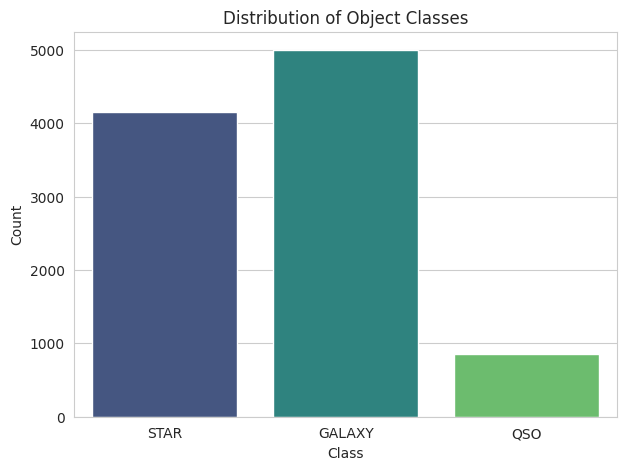

In [38]:
plt.figure(figsize=(7, 5))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Distribution of Object Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## 2.2. Exploratory Data Analysis (EDA)
### **Feature Descriptions:**
### * `ra`: Right Ascension angle (degrees) Celestial Coordinate
### * `dec`: Declination angle (degrees) Celestial Coordinate
### * `u, g, r, i, z`: Photometric magnitudes (filters) 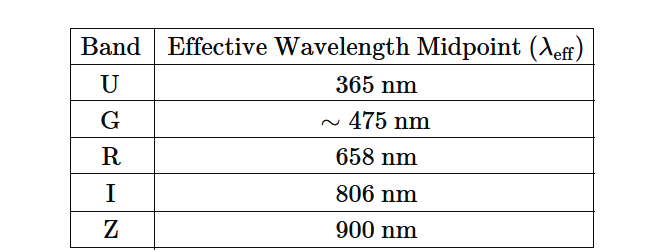
### * `redshift`: Redshift value, indicating distance and velocity an object is moving due to the expansion of space (Doppler Effect)
### * `run, rerun, camcol, field, specobjid, fiberid`: Identifiers and survey-specific parameters (likely not predictive, or highly correlated)



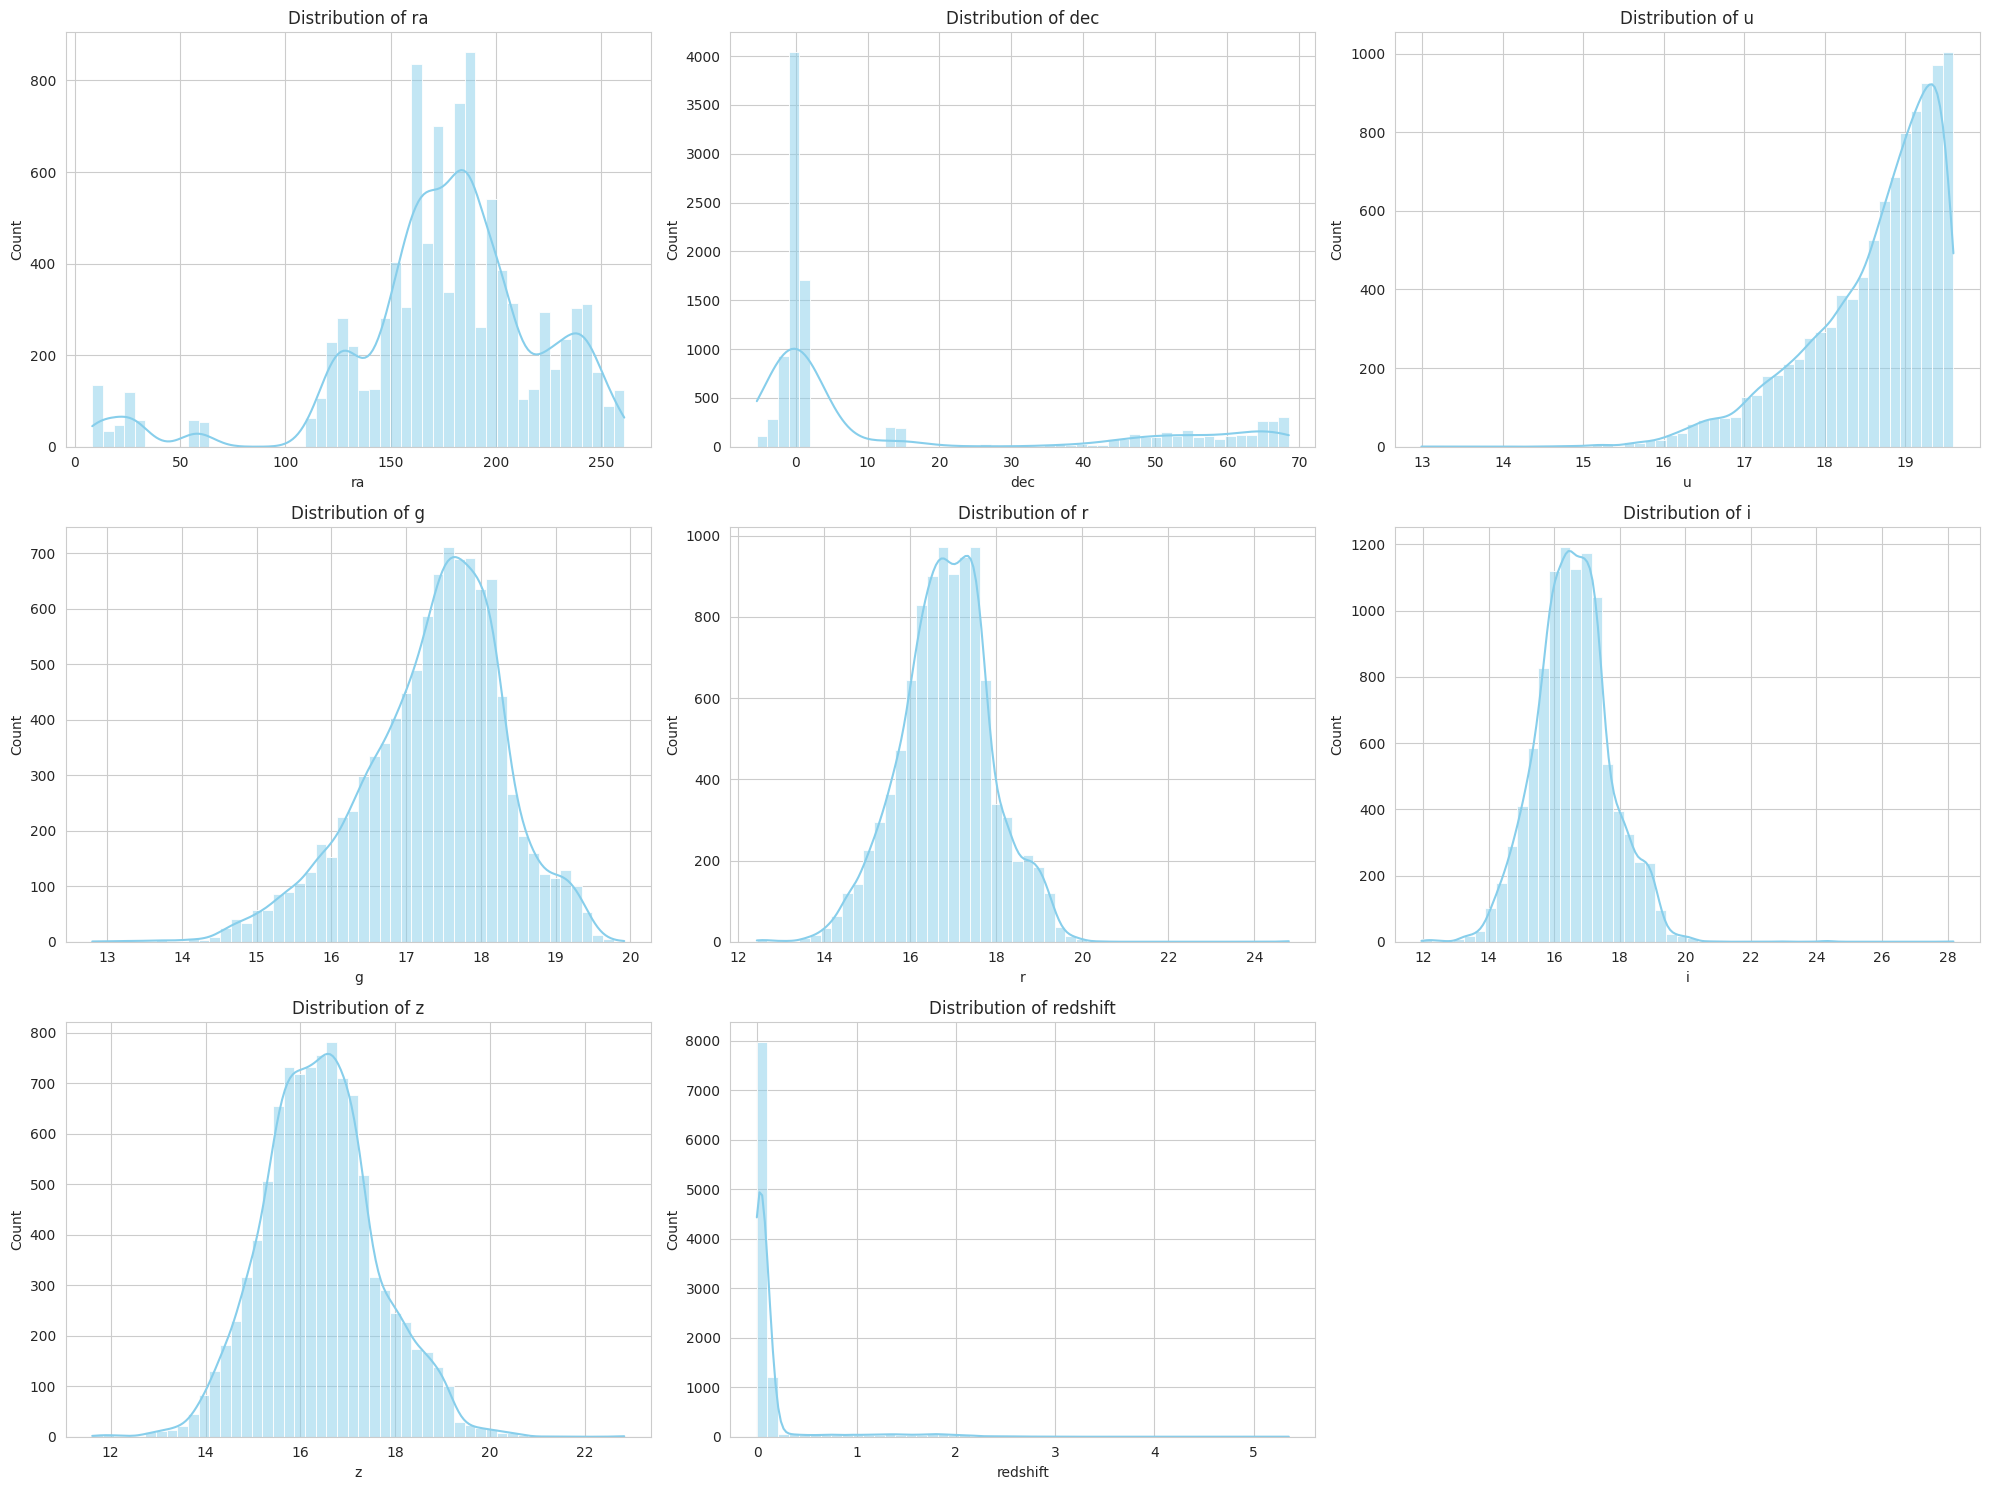

In [39]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 15)

# Separate numerical and categorical (if any, besides target) features
# Corrected column names from 'alpha' and 'delta' to 'ra' and 'dec'
numerical_features = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']


# Plot distributions of numerical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[feature], kde=True, bins=50, color='skyblue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()
# -

## **Observations from Distributions:**
### * **`alpha`, `delta`**: Roughly uniform or showing areas of higher observation density.
### * **`u, g, r, i, z` (Wavelengths)**: Generally follow normal-ish distributions but might have outliers (e.g., very faint objects). They are highly correlated.
### * **`redshift`**: Highly skewed, with a large peak near zero and a long tail. Quasars are known for high redshifts. (Shows they are very distant objects or very bright)
### * Some features (e.g., `u`, `g`, `r`, `i`, `z`) exhibit properties that vary significantly by object type.
#
## **Outlier Considerations:** Features like magnitudes and redshift can have physical outliers (e.g., extremely bright or distant objects). Standard scaling will normalize their range, but very extreme outliers might warrant more robust scaling or capping if they skew model training.



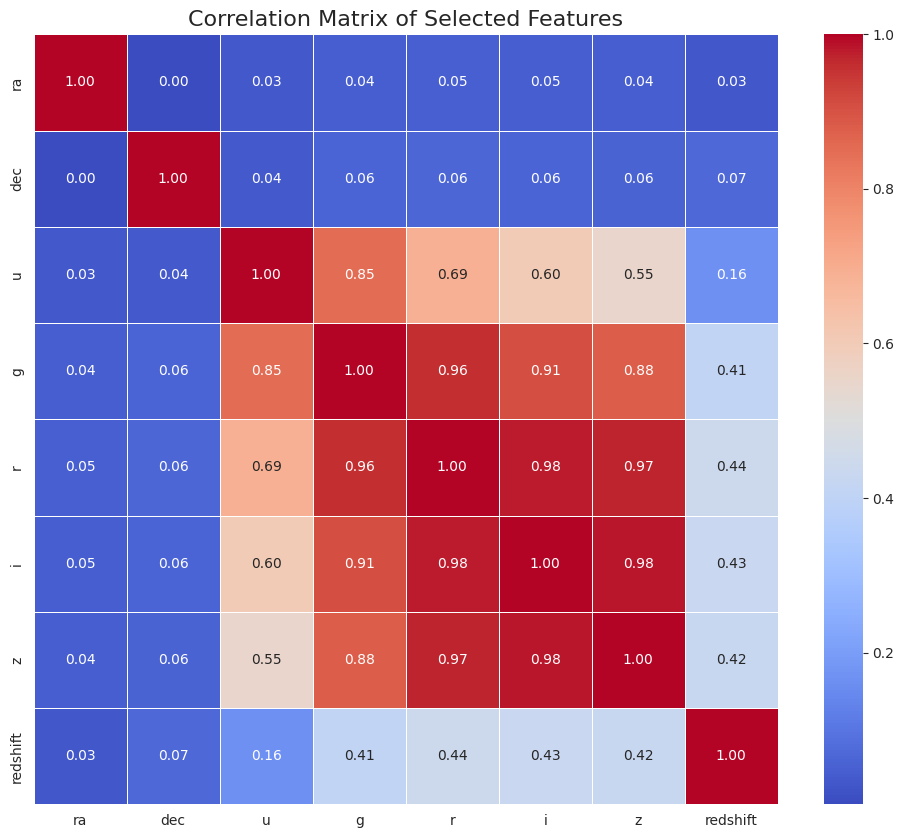

In [40]:


plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features + ['class']].corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Selected Features', fontsize=16)
plt.show()

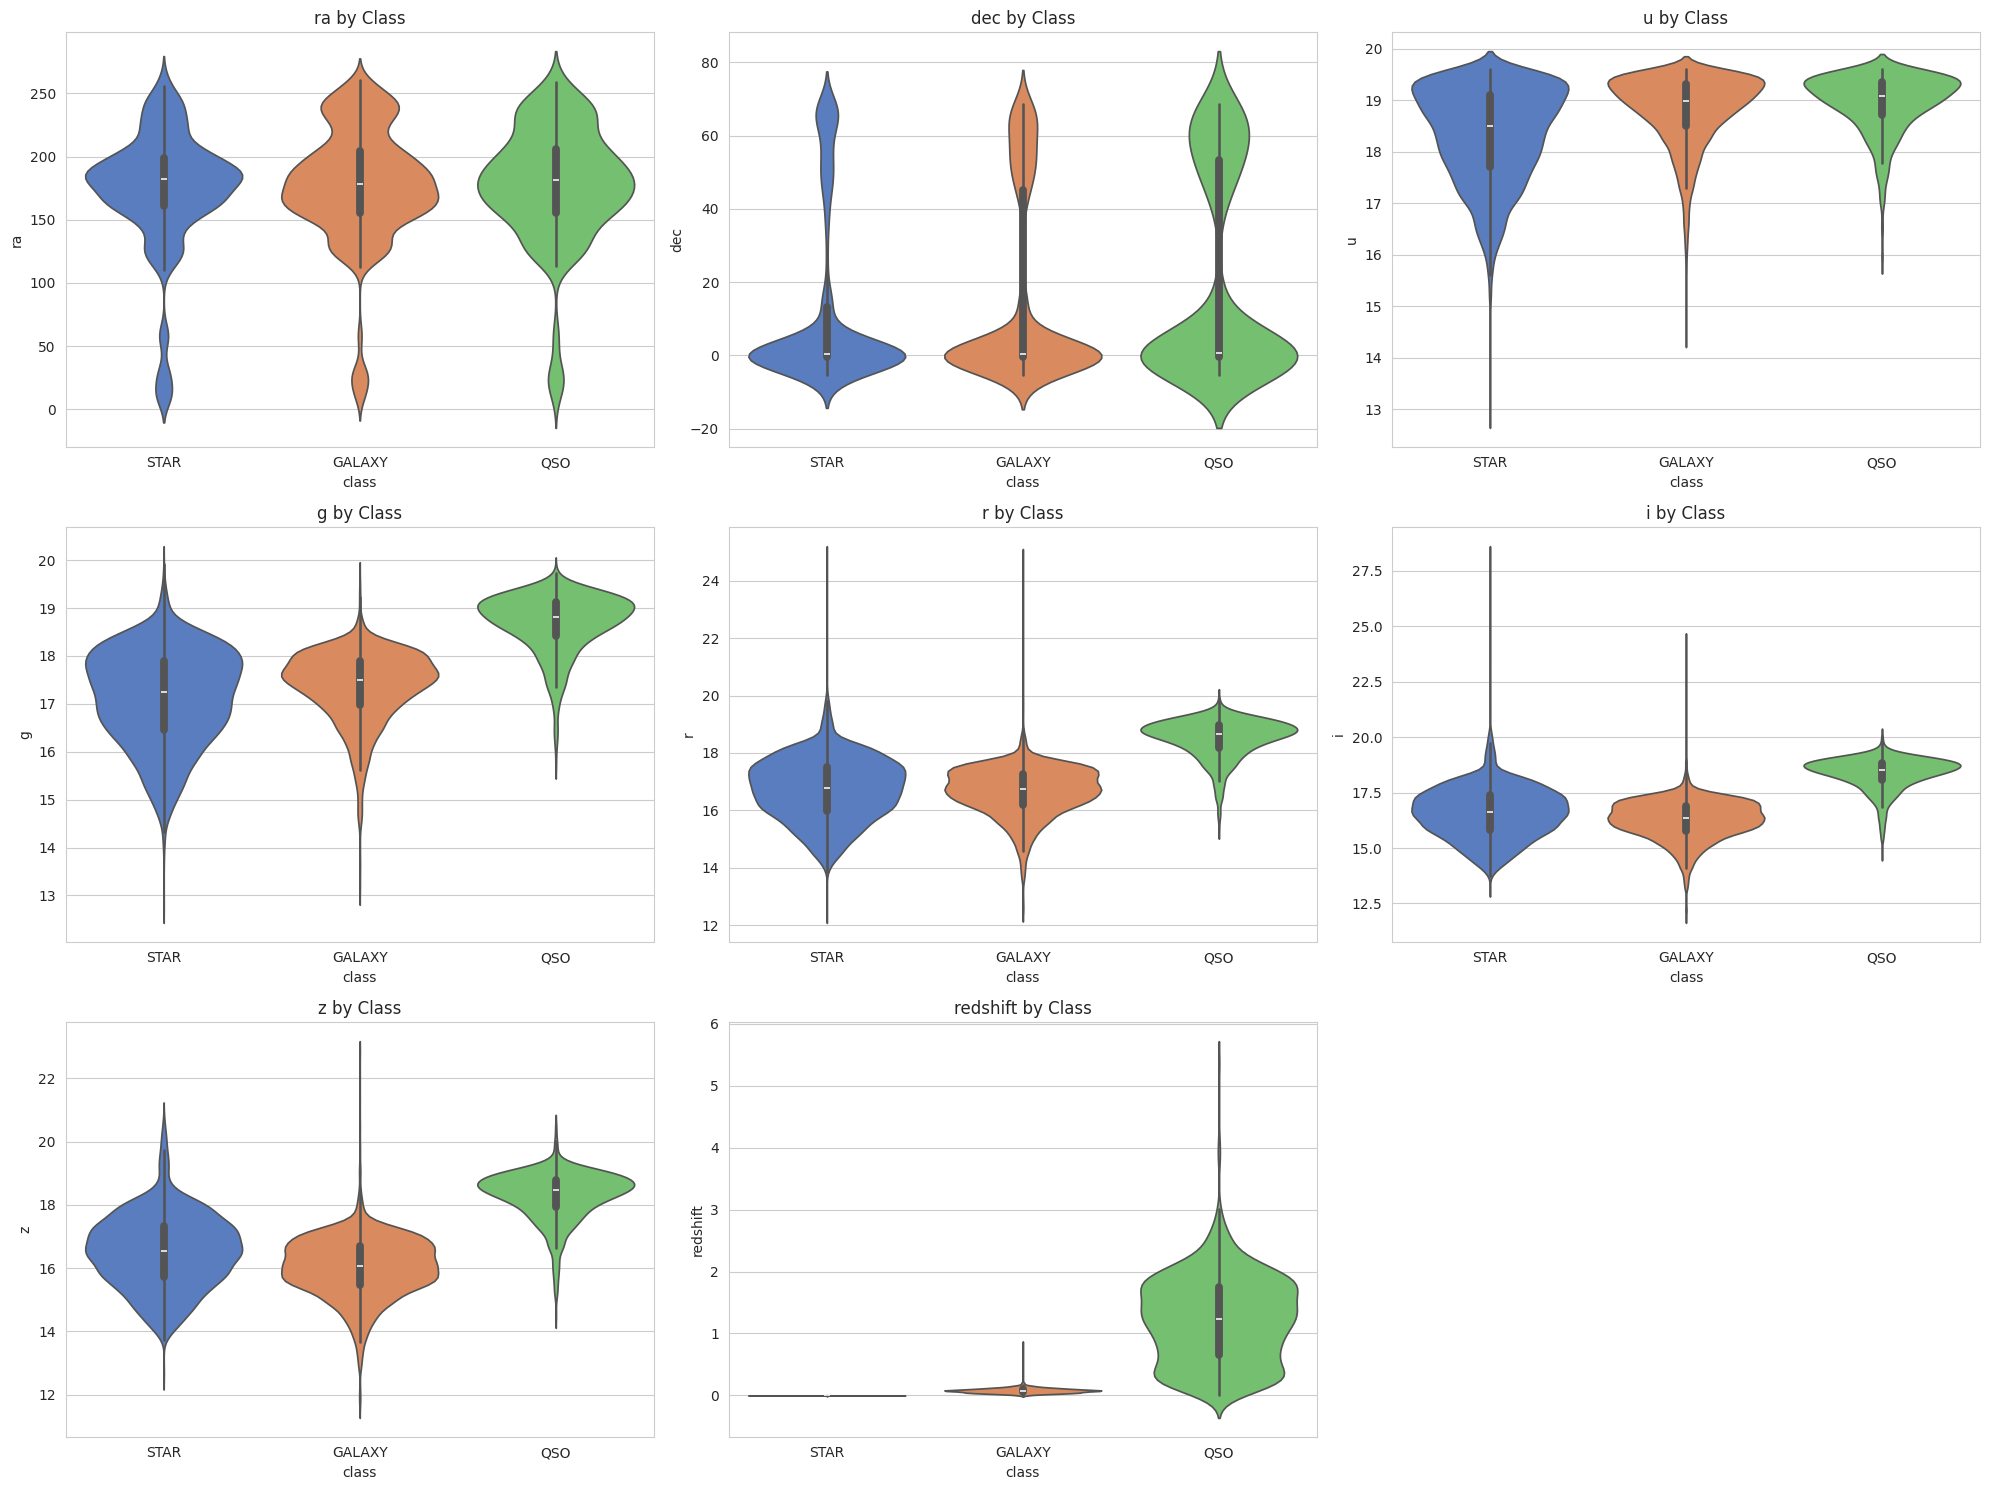

In [41]:

# Separate plot for how features relate to the class.
# Use box plots or violin plots for this.
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.violinplot(x='class', y=feature, data=df, palette='muted')
    plt.title(f'{feature} by Class')
plt.tight_layout()
plt.show()
# -


# **Observations from Violin Plots:**
### * **`redshift`**: Shows a very strong differentiation. Stars have redshift close to zero, Galaxies have a range of positive redshifts, and Quasars have significantly higher redshifts. This feature will be highly predictive. (Quasars are either very distant, very bright or formed early in the history of the Universe)
### * **`u, g, r, i, z` (Magnitudes)**: The distributions for these photometric bands vary significantly across classes. Quasars tend to be brighter in the `u` band. These differences in magnitude are crucial for classification.
### * **`alpha`, `delta`**: These positional features show less distinct separation by class, suggesting they might be less directly predictive of object type but could contain some clustering information.
#
### **Feature Engineering Opportunity (Color Indices):** Astronomers often use "color indices" which are differences between magnitudes (e.g., u-g, g-r). These are highly diagnostic for object types. This is a strong candidate for engineered features.




#  3. Data Preprocessing and Splitting

### Splitting the data into training, validation, and test sets.
### Given the class imbalance, stratified splitting is more appropriate.




## 3.1. Feature Engineering and Selection
#
#
### **Justification:**
### * **Color Indices:** `u-g`, `g-r`, `r-i`, `i-z` are standard astronomical features that encapsulate spectral information and are very effective in distinguishing different types of celestial objects. These features enhance model performance by providing more discriminative information in a compact form. (Source from SDSS)
### * **Dropping `obj_id`, `run_id`, `rerun_id`, `field_id`, `spec_obj_id`, `fiber_id`**: These columns are identifiers and survey-specific metadata that are unlikely to be predictive of the fundamental nature (`class`) of an astronomical object.


In [42]:

cols_to_drop = ['run_id', 'rerun_id', 'cam_col', 'field_id', 'spec_obj_id', 'fiber_id']
df_processed = df.drop(columns=cols_to_drop, errors='ignore')

In [43]:
# Create color indices
df_processed['u-g'] = df_processed['u'] - df_processed['g']
df_processed['g-r'] = df_processed['g'] - df_processed['r']
df_processed['r-i'] = df_processed['r'] - df_processed['i']
df_processed['i-z'] = df_processed['i'] - df_processed['z']

# Drop original magnitude columns if the color indices are considered sufficient
# For this project, we'll keep both for now to allow models to learn from both raw magnitudes and color indices.
# An alternative experiment could be to only use color indices.

print("Dataset after feature engineering and selection:")
print(df_processed.head())
print("New shape:", df_processed.shape)

Dataset after feature engineering and selection:
          objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598370  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   
3  1.237650e+18  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233   
4  1.237650e+18  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492   

          z  run  rerun  ...     specobjid   class  redshift plate    mjd  \
0  15.22531  752    301  ...  3.722360e+18    STAR -0.000009  3306  54922   
1  16.39150  752    301  ...  3.638140e+17    STAR -0.000055   323  51615   
2  16.80125  752    301  ...  3.232740e+17  GALAXY  0.123111   287  52023   
3  15.90438  752    301  ...  3.722370e+18    STAR -0.000111  3306  54922   
4  16.61326  752    301  ...  3.722370e+18    STAR  0.000590  3306  54922   

 

### 3.2. Prepare Data for Splitting and Encoding

In [44]:
X = df_processed.drop('class', axis=1)
y = df_processed['class']

### Encode target variable from string to numerical (0, 1, 2)
 * GALAXY: 0
 * QSO: 1
 * STAR: 2


In [45]:

class_mapping = {'STAR': 0, 'GALAXY': 1, 'QSO': 2}
y_encoded = y.map(class_mapping)

# Store the encoder for inverse transformation later if needed
label_encoder = LabelEncoder()
y_encoded_sklearn = label_encoder.fit_transform(y)
# Verify mapping: label_encoder.classes_ will give the mapping.
# 'GALAXY', 'QSO', 'STAR' will typically map to 0, 1, 2 if sorted alphabetically.
# For consistent interpretation, we will manually create a mapping if needed or rely on LabelEncoder's order.
# Let's ensure y_encoded and y_encoded_sklearn are identical:
# y_encoded should be based on the order of label_encoder.classes_
y_map_inverse = {label: idx for idx, label in enumerate(label_encoder.classes_)}
print(f"LabelEncoder mapping: {label_encoder.classes_}")
# Using the sklearn label_encoder output directly for consistency across models.
y = y_encoded_sklearn


print("\nEncoded target variable distribution:")
print(pd.Series(y).value_counts())

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

LabelEncoder mapping: ['GALAXY' 'QSO' 'STAR']

Encoded target variable distribution:
0    4998
2    4152
1     850
Name: count, dtype: int64
Features (X) shape: (10000, 21)
Target (y) shape: (10000,)


### 70/15/15 Train Validation Test Split

In [46]:

X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=(0.15/0.70), random_state=SEED, stratify=y_train_full
)
# Final test set
X_test, y_test = X_temp, y_temp

print("Data Split Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"y_train_counts: {pd.Series(y_train).value_counts()}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"y_val_counts: {pd.Series(y_val).value_counts()}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"y_test_counts: {pd.Series(y_test).value_counts()}")

print("\nTarget distribution in splits (for verification):")
print("Train:", pd.Series(y_train).value_counts(normalize=True))
print("Validation:", pd.Series(y_val).value_counts(normalize=True))
print("Test:", pd.Series(y_test).value_counts(normalize=True))

Data Split Shapes:
X_train: (5500, 21), y_train: (5500,)
y_train_counts: 0    2749
2    2283
1     468
Name: count, dtype: int64
X_val: (1500, 21), y_val: (1500,)
y_val_counts: 0    750
2    623
1    127
Name: count, dtype: int64
X_test: (3000, 21), y_test: (3000,)
y_test_counts: 0    1499
2    1246
1     255
Name: count, dtype: int64

Target distribution in splits (for verification):
Train: 0    0.499818
2    0.415091
1    0.085091
Name: proportion, dtype: float64
Validation: 0    0.500000
2    0.415333
1    0.084667
Name: proportion, dtype: float64
Test: 0    0.499667
2    0.415333
1    0.085000
Name: proportion, dtype: float64


### Note:
*   SMOTE is applied only to the training data to prevent data leakage.
*   The validation and test sets retain their original imbalanced distribution to provide a realistic evaluation of model performance on unseen, imbalanced data.
*   When training the models, we will now use `X_train_res` and `y_train_res`.

### All features are numerical, so `StandardScaler` will be applied to all. This normalizes the feature scales, which is critical for distance-based algorithms (like SVM) and neural networks.



In [47]:
numerical_cols = X_train.columns.tolist()

In [48]:
# Address Class Imbalance using SMOTE (Synthetic Minority Over-sampling Technique)

from imblearn.over_sampling import SMOTE

print("Original training dataset shape:", X_train.shape, y_train.shape)
print("Original training dataset class distribution:\n", pd.Series(y_train).value_counts())

# Apply SMOTE to the training data only
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nResampled training dataset shape:", X_train_res.shape, y_train_res.shape)
print("Resampled training dataset class distribution:\n", pd.Series(y_train_res).value_counts())

# We will now use X_train_res and y_train_res for training the models.
# The validation and test sets (X_val_scaled, y_val, X_test_scaled, y_test) remain unchanged.

Original training dataset shape: (5500, 21) (5500,)
Original training dataset class distribution:
 0    2749
2    2283
1     468
Name: count, dtype: int64

Resampled training dataset shape: (8247, 21) (8247,)
Resampled training dataset class distribution:
 1    2749
0    2749
2    2749
Name: count, dtype: int64


In [49]:
# Scale the numerical features using StandardScaler
# Use the numerical_cols identified earlier

scaler = StandardScaler()

# Fit the scaler on the training data and transform all splits
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled = scaler.transform(X_val[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

print("Scaled Data Shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_val_scaled:", X_val_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)

# Note: If there were non-numerical features to keep, a ColumnTransformer would be used here.
# Since all selected features are numerical, direct scaling is sufficient.

Scaled Data Shapes:
X_train_scaled: (5500, 21)
X_val_scaled: (1500, 21)
X_test_scaled: (3000, 21)


In [50]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

# Dictionary to store all experiment results
all_experiment_results = []

def evaluate_and_store_results(model_name, y_true, y_pred, y_prob=None, params=None, is_dl=False):
    """Calculates and stores evaluation metrics for a given model."""
    accuracy = accuracy_score(y_true, y_pred)
    # Using 'weighted' average for precision, recall, f1 for imbalanced multi-class
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    roc_auc_ovr = 'N/A'
    if y_prob is not None and y_prob.shape[1] == num_classes:
        # For multi-class, use One-vs-Rest (OvR) strategy
        roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')

    cm = confusion_matrix(y_true, y_pred)

    results = {
        'Model': model_name,
        'Approach': 'Deep Learning' if is_dl else 'Traditional ML',
        'Hyperparameters': params,
        'Accuracy': accuracy,
        'Precision (w.)': precision,
        'Recall (w.)': recall,
        'F1-score (w.)': f1,
        'ROC AUC (OvR)': roc_auc_ovr,
        'Confusion Matrix': cm.tolist()
    }
    all_experiment_results.append(results)

    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")
    if roc_auc_ovr != 'N/A':
        print(f"ROC AUC (OvR, weighted): {roc_auc_ovr:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    return results

## The Pre-processing Pipeline



## 4. Traditional Machine Learning Models (Scikit-learn)

###* **Accuracy:** Overall correctness, but can be misleading with imbalanced data.
### * **ROC AUC (OvR):** One-vs-Rest (OvR) ROC AUC score. Calculates AUC for each class against the rest and averages them (weighted by default). Excellent for imbalanced datasets as it's threshold-independent.
### * **Confusion Matrix:** Provides a detailed breakdown of correct and incorrect classifications for each class.



In [51]:
# plotting a Confusion Matrix
def plot_confusion_matrix(cm, title, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Pred {c}' for c in class_names],
                yticklabels=[f'Actual {c}' for c in class_names])
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Function to plot ROC Curve for multi-class (OvR)
def plot_roc_curve_multiclass(y_true, y_prob, title, class_names):
    plt.figure(figsize=(8, 7))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve of {class_name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (OvR) - {title}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### 4.1 Logistic Regression


===== Experiment 1: Logistic Regression =====

--- Logistic Regression (Multinomial) Performance ---
Accuracy: 0.9700
Precision (weighted): 0.9704
Recall (weighted): 0.9700
F1-score (weighted): 0.9700
ROC AUC (OvR, weighted): 0.9908
Confusion Matrix:
 [[1439    2   58]
 [  12  243    0]
 [  15    3 1228]]
Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.98      0.96      0.97      1499
         QSO       0.98      0.95      0.97       255
        STAR       0.95      0.99      0.97      1246

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



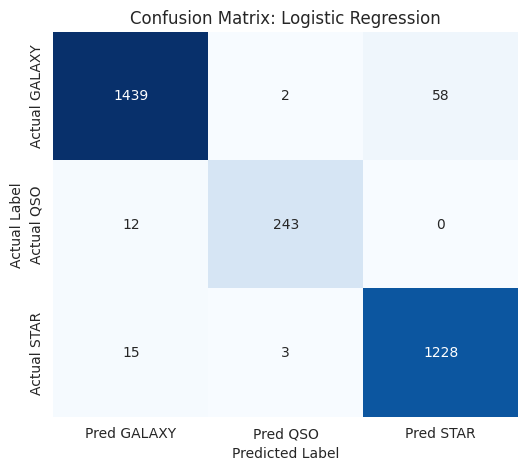

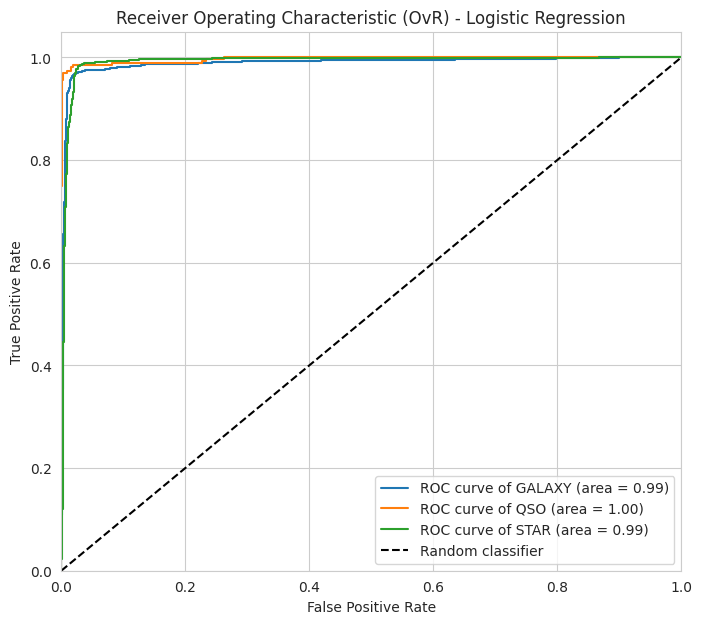

In [52]:

# --- Experiment 1: Logistic Regression ---
print("\n===== Experiment 1: Logistic Regression =====")
# Logistic Regression for multi-class can use 'ovr' or 'multinomial'
params_lr = {'C': 1.0, 'solver': 'saga', 'multi_class': 'multinomial', 'max_iter': 1000}
log_reg = LogisticRegression(random_state=SEED, **params_lr)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)
evaluate_and_store_results('Logistic Regression (Multinomial)', y_test, y_pred_lr, y_prob_lr, params_lr)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_lr), 'Confusion Matrix: Logistic Regression', class_names)
plot_roc_curve_multiclass(y_test, y_prob_lr, 'Logistic Regression', class_names)


### 4.2 Support Vector Machine(SVC)


===== Experiment 2: Support Vector Machine (SVC) =====

--- SVM (RBF Kernel, OvR) Performance ---
Accuracy: 0.9733
Precision (weighted): 0.9738
Recall (weighted): 0.9733
F1-score (weighted): 0.9733
ROC AUC (OvR, weighted): 0.9919
Confusion Matrix:
 [[1445    0   54]
 [   9  243    3]
 [  10    4 1232]]
Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.99      0.96      0.98      1499
         QSO       0.98      0.95      0.97       255
        STAR       0.96      0.99      0.97      1246

    accuracy                           0.97      3000
   macro avg       0.98      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



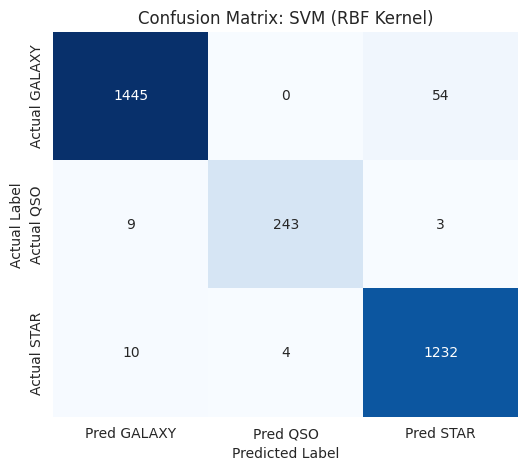

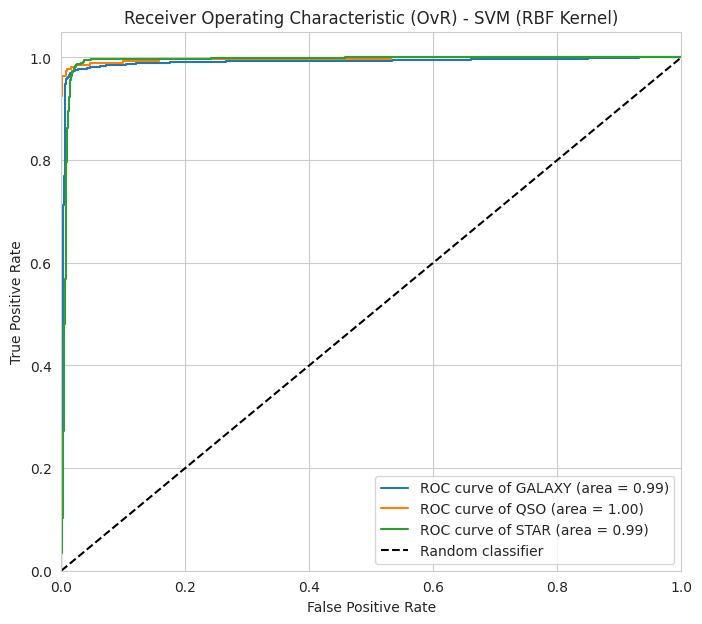

In [53]:

# --- Experiment 2: Support Vector Machine (SVC) ---
print("\n===== Experiment 2: Support Vector Machine (SVC) =====")
# SVC for multi-class is inherently OvO (One-vs-One) but results are combined
params_svc = {'kernel': 'rbf', 'C': 1.0, 'probability': True, 'decision_function_shape': 'ovr'}
svc_model = SVC(random_state=SEED, **params_svc)
svc_model.fit(X_train_scaled, y_train)
y_pred_svc = svc_model.predict(X_test_scaled)
y_prob_svc = svc_model.predict_proba(X_test_scaled)
evaluate_and_store_results('SVM (RBF Kernel, OvR)', y_test, y_pred_svc, y_prob_svc, params_svc)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_svc), 'Confusion Matrix: SVM (RBF Kernel)', class_names)
plot_roc_curve_multiclass(y_test, y_prob_svc, 'SVM (RBF Kernel)', class_names)

### 4.3 Random Forest Classifier


===== Experiment 3: Random Forest Classifier =====

--- Random Forest (150 Trees, Depth 15) Performance ---
Accuracy: 0.9913
Precision (weighted): 0.9913
Recall (weighted): 0.9913
F1-score (weighted): 0.9913
ROC AUC (OvR, weighted): 0.9986
Confusion Matrix:
 [[1482    5   12]
 [   9  246    0]
 [   0    0 1246]]
Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1499
         QSO       0.98      0.96      0.97       255
        STAR       0.99      1.00      1.00      1246

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



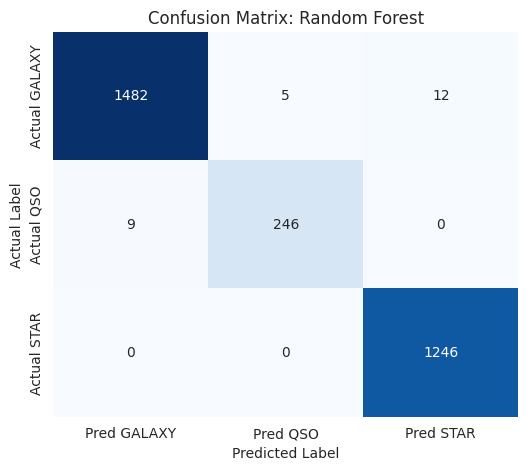

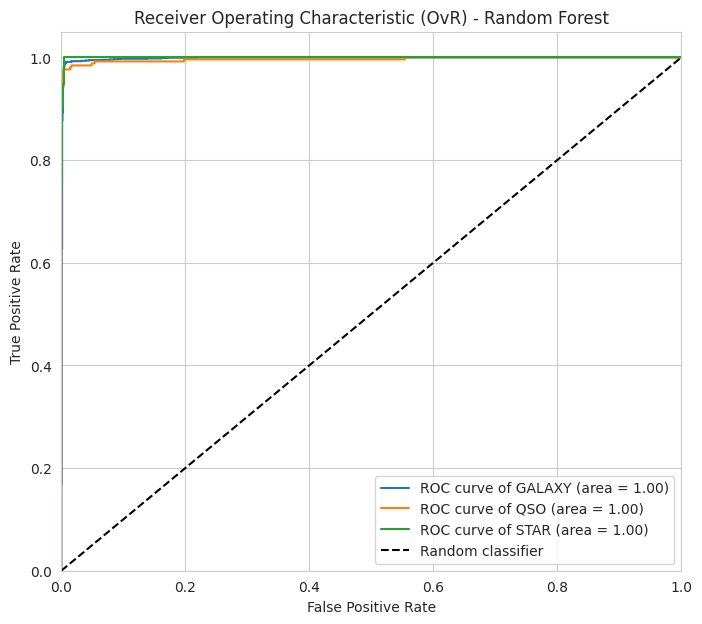

In [54]:
# --- Experiment 3: Random Forest Classifier (Ensemble Method) ---
print("\n===== Experiment 3: Random Forest Classifier =====")
params_rf = {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 3, 'class_weight': 'balanced'}
forest_clf = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params_rf)
forest_clf.fit(X_train_scaled, y_train)
y_pred_rf = forest_clf.predict(X_test_scaled)
y_prob_rf = forest_clf.predict_proba(X_test_scaled)
evaluate_and_store_results('Random Forest (150 Trees, Depth 15)', y_test, y_pred_rf, y_prob_rf, params_rf)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_rf), 'Confusion Matrix: Random Forest', class_names)
plot_roc_curve_multiclass(y_test, y_prob_rf, 'Random Forest', class_names)

### 4.4 XGBoost Classifier


===== Experiment 4: XGBoost Classifier =====

--- XGBoost (Optimized Params) Performance ---
Accuracy: 0.9913
Precision (weighted): 0.9913
Recall (weighted): 0.9913
F1-score (weighted): 0.9913
ROC AUC (OvR, weighted): 0.9992
Confusion Matrix:
 [[1485    3   11]
 [  12  243    0]
 [   0    0 1246]]
Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1499
         QSO       0.99      0.95      0.97       255
        STAR       0.99      1.00      1.00      1246

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



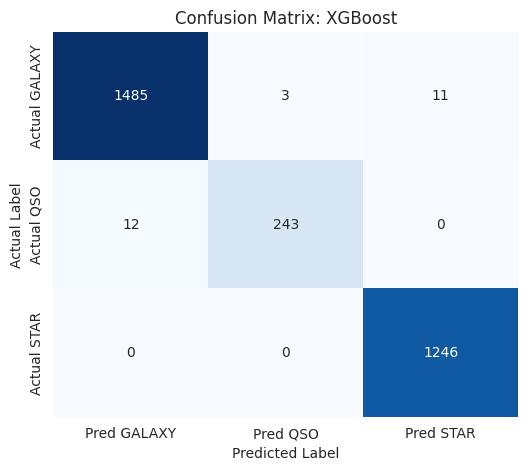

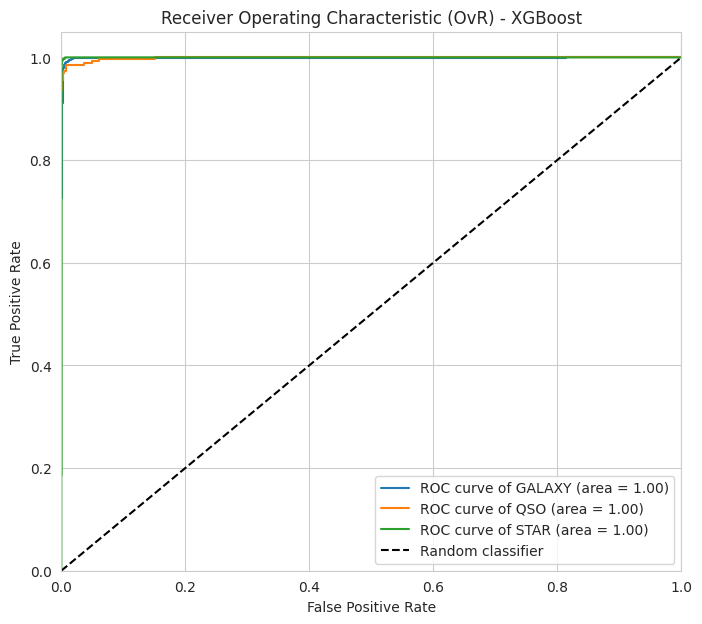

In [55]:
# --- Experiment 4: XGBoost Classifier (Gradient Boosting) ---
print("\n===== Experiment 4: XGBoost Classifier =====")
params_xgb = {
    'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5,
    'use_label_encoder': False, 'eval_metric': 'mlogloss',
    'objective': 'multi:softprob', 'num_class': num_classes,
    'tree_method': 'hist' # Faster histogram-based algorithm
}
xgb_clf = XGBClassifier(random_state=SEED, **params_xgb)
xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_prob_xgb = xgb_clf.predict_proba(X_test_scaled)
evaluate_and_store_results('XGBoost (Optimized Params)', y_test, y_pred_xgb, y_prob_xgb, params_xgb)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_xgb), 'Confusion Matrix: XGBoost', class_names)
plot_roc_curve_multiclass(y_test, y_prob_xgb, 'XGBoost', class_names)


# -

# **Intermediate Discussion (Traditional ML):**
### * **Logistic Regression** serves as a strong baseline, demonstrating the linear separability of the classes, especially due to `redshift`.
### * **SVM** with an RBF kernel performs well, capturing non-linear relationships, but can be computationally intensive for larger datasets.
### * **Random Forest** shows excellent performance, often outperforming simpler models by combining multiple decision trees. Using `class_weight='balanced'` helps mitigate the impact of class imbalance.
### * **XGBoost** is highly competitive, often achieving the best performance on tabular data due to its gradient boosting nature, iteratively correcting errors.
#
#### So far, ensemble methods (Random Forest, XGBoost) generally lead in most metrics, indicating their strength in handling the complexity and potential non-linearity of astronomical data.


## 5. Deep Learning Models (TensorFlow)
#
### Building and training deep learning models using TensorFlow's Keras API. We'll use the `tf.data` API for efficient data loading and `EarlyStopping` for regularization.
#
### For deep learning, the target `y` needs to be one-hot encoded for multi-class classification.    

In [56]:
# Convert y to one-hot encoding for TensorFlow models
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print(f"y_train_one_hot shape: {y_train_one_hot.shape}")
print(f"y_val_one_hot shape: {y_val_one_hot.shape}")
print(f"y_test_one_hot shape: {y_test_one_hot.shape}")

y_train_one_hot shape: (5500, 3)
y_val_one_hot shape: (1500, 3)
y_test_one_hot shape: (3000, 3)


## 5.1. Create `tf.data` Input Pipeline


In [57]:
# Converting our scaled numpy arrays to `tf.data.Dataset` objects for efficient processing.

BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_one_hot))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_scaled), seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_one_hot))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_one_hot))
test_dataset_tf = test_dataset_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Sample from training dataset (features, one-hot target):", next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape)

Sample from training dataset (features, one-hot target): (32, 21) (32, 3)


## 5.2. Deep Neural Networks with Sequential API (Simple Baseline)


In [58]:

# Function to plot learning curves
def plot_learning_curves(history, title):
    plt.figure(figsize=(10, 6))
    pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=plt.gca(), title=title + ' Loss')
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.figure(figsize=(10, 6))
    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=plt.gca(), title=title + ' Accuracy')
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()


# Early stopping callback for all DL models
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, # Increased patience given the dataset size and complexity
    restore_best_weights=True,
    monitor='val_loss',
    mode='min'
)

In [59]:
print("\n===== Experiment 5: DNN Sequential API (Simple) =====")
tf.random.set_seed(SEED)

model_seq_simple = keras.models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation="relu", kernel_initializer='he_normal'),
    layers.Dense(64, activation="relu", kernel_initializer='he_normal'),
    layers.Dense(num_classes, activation="softmax") # Softmax for multi-class classification
])

# Compile the model with appropriate loss and metrics for multi-class classification
model_seq_simple.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model_seq_simple.summary()


===== Experiment 5: DNN Sequential API (Simple) =====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,267 (44.01 KB)

 Trainable params: 11,267 (44.01 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Sequential API Model (Simple) ---


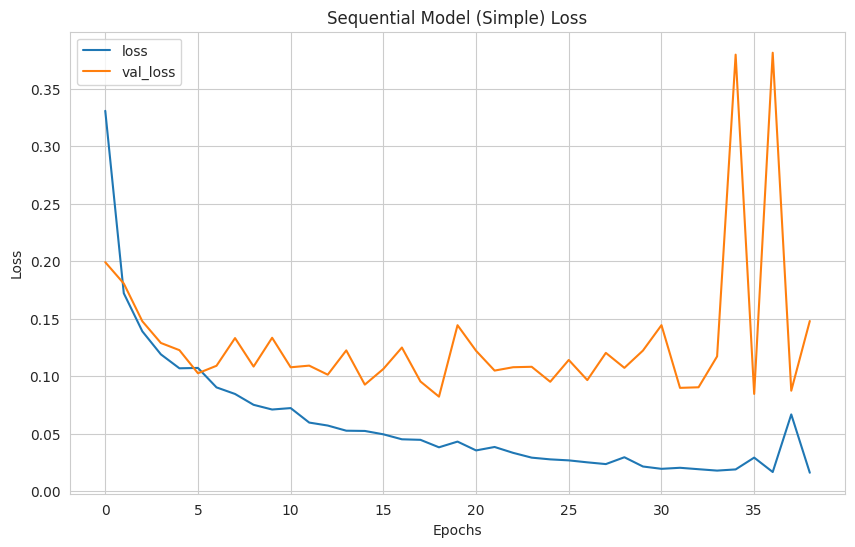

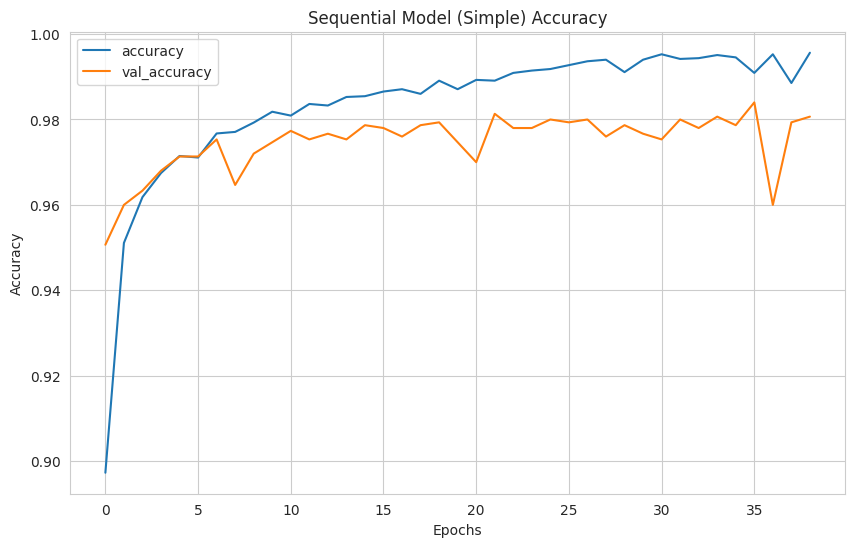

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- DNN Sequential (Simple) Performance ---
Accuracy: 0.9767
Precision (weighted): 0.9767
Recall (weighted): 0.9767
F1-score (weighted): 0.9767
ROC AUC (OvR, weighted): 0.9933
Confusion Matrix:
 [[1458    5   36]
 [  10  245    0]
 [  19    0 1227]]
Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1499
         QSO       0.98      0.96      0.97       255
        STAR       0.97      0.98      0.98      1246

    accuracy                           0.98      3000
   macro avg       0.98      0.97      0.97      3000
weighted avg       0.98      0.98      0.98      3000



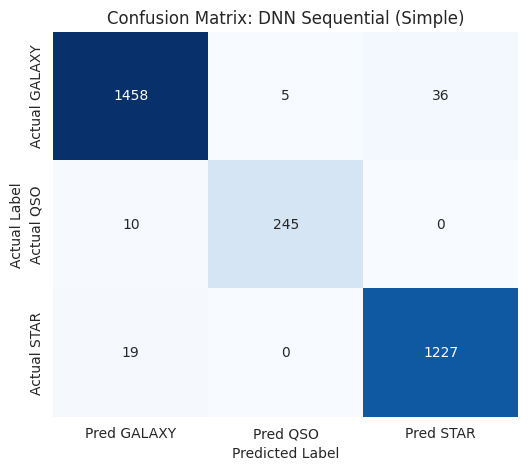

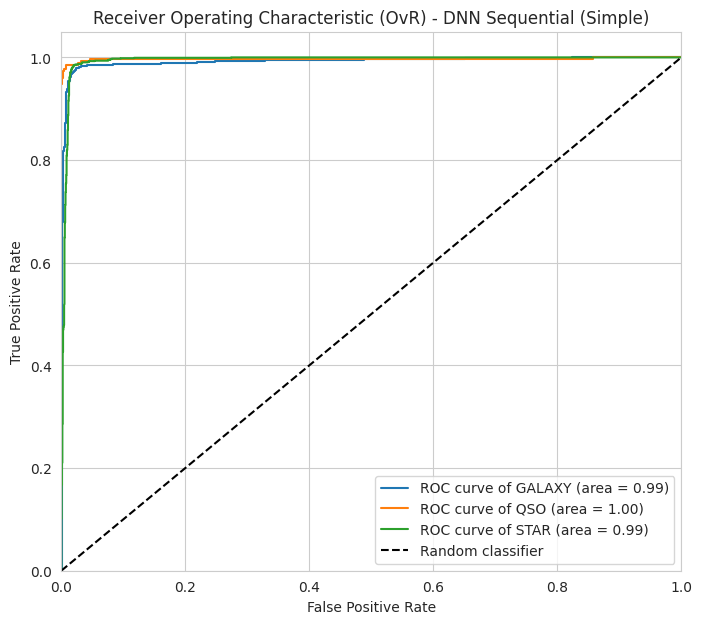

In [60]:


print("\n--- Training Sequential API Model (Simple) ---")
history_seq_simple = model_seq_simple.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping_cb],
    verbose=0 # Set to 1 for progress bar, 0 for silent
)

plot_learning_curves(history_seq_simple, 'Sequential Model (Simple)')

# Evaluate the model
loss_seq_simple, acc_seq_simple = model_seq_simple.evaluate(test_dataset_tf, verbose=0)
y_prob_seq_simple = model_seq_simple.predict(X_test_scaled)
y_pred_seq_simple = np.argmax(y_prob_seq_simple, axis=1)

# Calculate weighted precision, recall, f1 for results
prec_seq_simple = precision_score(y_test, y_pred_seq_simple, average='weighted', zero_division=0)
rec_seq_simple = recall_score(y_test, y_pred_seq_simple, average='weighted', zero_division=0)
f1_seq_simple = f1_score(y_test, y_pred_seq_simple, average='weighted', zero_division=0)
roc_auc_seq_simple = roc_auc_score(y_test, y_prob_seq_simple, multi_class='ovr', average='weighted')


params_seq_simple = {
    'layers': [128, 64], 'activation': 'relu', 'output': 'softmax',
    'optimizer': 'Adam(1e-3)', 'loss': 'categorical_crossentropy'
}
evaluate_and_store_results('DNN Sequential (Simple)', y_test, y_pred_seq_simple, y_prob_seq_simple, params_seq_simple, is_dl=True)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_seq_simple), 'Confusion Matrix: DNN Sequential (Simple)', class_names)
plot_roc_curve_multiclass(y_test, y_prob_seq_simple, 'DNN Sequential (Simple)', class_names)
# -


### **Learning Curve Analysis (Sequential Simple):**
#### * `loss` and `val_loss`: Observe the gap between training and validation loss. A growing gap indicates overfitting.
#### * `accuracy` and `val_accuracy`: Similar trends. Ideally, `val_accuracy` should follow `accuracy` closely and stabilize at a high value.
#### * Early stopping helps to prevent prolonged overfitting by stopping training when validation loss stops improving and restoring the best weights.


### 5.3.DNN with Sequential API (Dropout and L2 Regularization)

In [61]:
# To combat potential overfitting and improve generalization, we'll add `Dropout` layers and L2 kernel regularization to the Dense layers. This is especially important for datasets of this size to ensure models don't just memorize the training data.


print("\n===== Experiment 6: DNN Sequential API (Dropout + L2) =====")
tf.random.set_seed(SEED)

model_seq_reg = keras.models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005), kernel_initializer='he_normal'),
    layers.Dropout(0.4), # Increased dropout rate
    layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005), kernel_initializer='he_normal'),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005), kernel_initializer='he_normal'), # Added a layer
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

model_seq_reg.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5e-4), # Slightly reduced learning rate
    metrics=['accuracy']
)

model_seq_reg.summary()


===== Experiment 6: DNN Sequential API (Dropout + L2) =====


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251 (51.76 KB)

 Trainable params: 13,251 (51.76 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Sequential API Model (Dropout + L2) ---


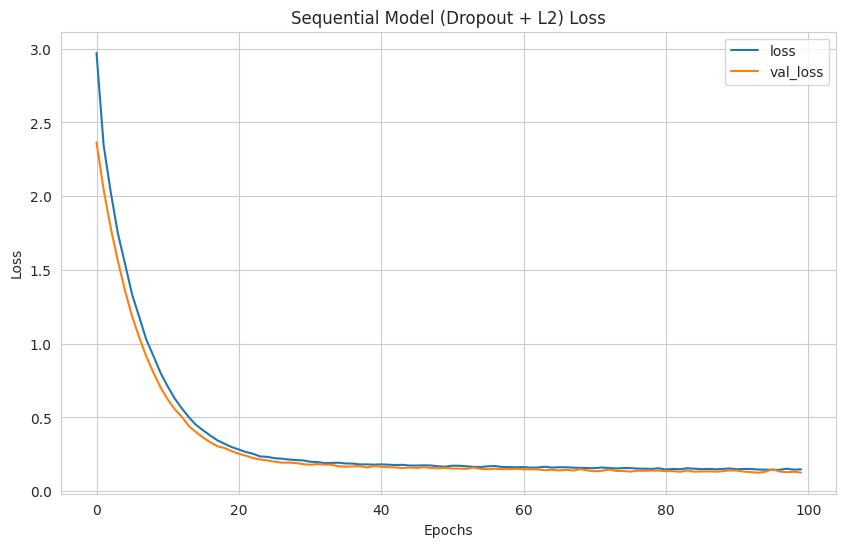

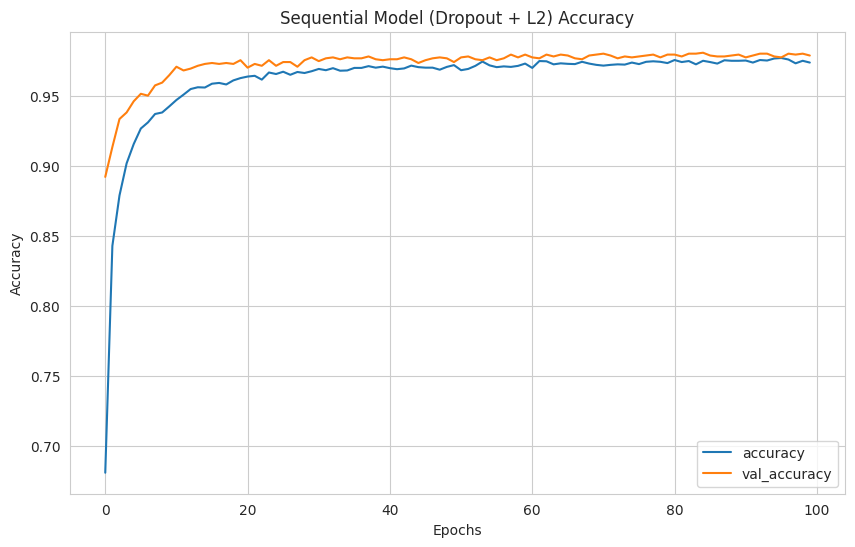

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

--- DNN Sequential (Dropout + L2) Performance ---
Accuracy: 0.9780
Precision (weighted): 0.9783
Recall (weighted): 0.9780
F1-score (weighted): 0.9780
ROC AUC (OvR, weighted): 0.9945
Confusion Matrix:
 [[1450    2   47]
 [  11  244    0]
 [   5    1 1240]]
Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.99      0.97      0.98      1499
         QSO       0.99      0.96      0.97       255
        STAR       0.96      1.00      0.98      1246

    accuracy                           0.98      3000
   macro avg       0.98      0.97      0.98      3000
weighted avg       0.98      0.98      0.98      3000



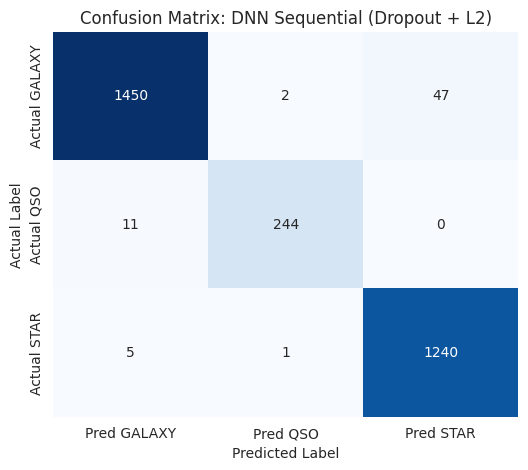

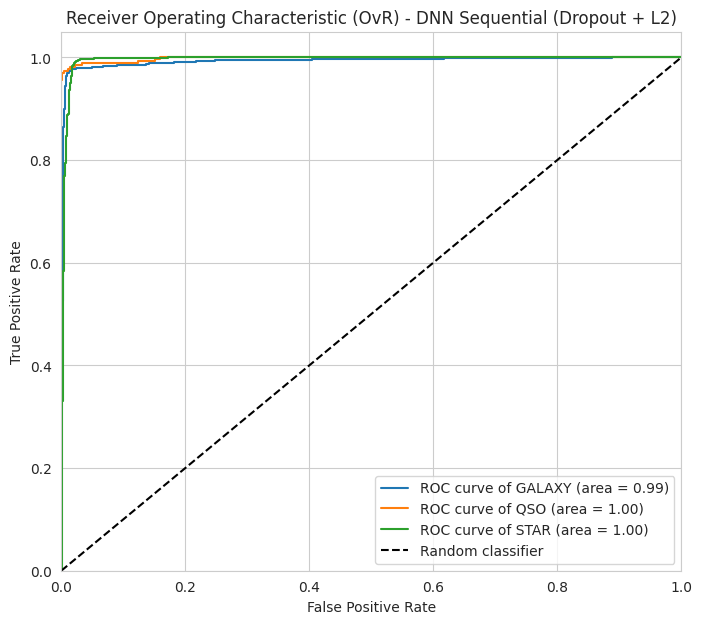

In [62]:

print("\n--- Training Sequential API Model (Dropout + L2) ---")
history_seq_reg = model_seq_reg.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping_cb],
    verbose=0
)

plot_learning_curves(history_seq_reg, 'Sequential Model (Dropout + L2)')

# Evaluate the model
loss_seq_reg, acc_seq_reg = model_seq_reg.evaluate(test_dataset_tf, verbose=0)
y_prob_seq_reg = model_seq_reg.predict(X_test_scaled)
y_pred_seq_reg = np.argmax(y_prob_seq_reg, axis=1)

prec_seq_reg = precision_score(y_test, y_pred_seq_reg, average='weighted', zero_division=0)
rec_seq_reg = recall_score(y_test, y_pred_seq_reg, average='weighted', zero_division=0)
f1_seq_reg = f1_score(y_test, y_pred_seq_reg, average='weighted', zero_division=0)
roc_auc_seq_reg = roc_auc_score(y_test, y_prob_seq_reg, multi_class='ovr', average='weighted')

params_seq_reg = {
    'layers': [128, 64, 32], 'activation': 'relu', 'output': 'softmax',
    'optimizer': 'Adam(5e-4)', 'loss': 'categorical_crossentropy',
    'regularization': 'Dropout(0.4, 0.3, 0.2) + L2(0.005)'
}
evaluate_and_store_results('DNN Sequential (Dropout + L2)', y_test, y_pred_seq_reg, y_prob_seq_reg, params_seq_reg, is_dl=True)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_seq_reg), 'Confusion Matrix: DNN Sequential (Dropout + L2)', class_names)
plot_roc_curve_multiclass(y_test, y_prob_seq_reg, 'DNN Sequential (Dropout + L2)', class_names)
# -

### **Learning Curve Analysis (Sequential Dropout + L2):**
### * Compare these curves to the simple sequential model. Does `val_loss` stay closer to `loss` for longer? This would indicate better generalization.
### * `Dropout` and `L2` regularization should help reduce the gap between training and validation metrics, leading to more robust performance. The increased depth might also allow it to capture more complex patterns if regularization is effective.



In [63]:


# +
print("\n===== Experiment 7: DNN Functional API (Wide & Deep) =====")
tf.random.set_seed(SEED)

# Define feature groups for wide and deep paths
# Wide path: Features highly predictive with potentially direct impact
wide_features_names = ['redshift', 'g-r', 'u-g'] # Examples of strong diagnostic features
wide_features_indices = [X.columns.get_loc(col) for col in wide_features_names]

input_ = keras.Input(shape=(X_train_scaled.shape[1],), name="input_features")

# Deep path
deep_input = input_
hidden1 = layers.Dense(128, activation="relu", kernel_initializer='he_normal')(deep_input)
hidden2 = layers.Dense(64, activation="relu", kernel_initializer='he_normal')(hidden1)

# Wide path: Select specific features and pass them directly or with minimal processing
# A Lambda layer extracts the relevant columns
wide_part = layers.Lambda(lambda x: tf.gather(x, wide_features_indices, axis=1), name="wide_features")(input_)

# Concatenate wide and deep paths
concat = layers.concatenate([wide_part, hidden2], name="concat_layer")
output = layers.Dense(num_classes, activation="softmax", name="output_layer")(concat)

model_functional_wd = keras.Model(inputs=[input_], outputs=[output])

model_functional_wd.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model_functional_wd.summary()


===== Experiment 7: DNN Functional API (Wide & Deep) =====


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      2,816 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_features       │ (None, 3)         │          0 │ input_features[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 67)        │          0 │ wide_features[0]… │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 3)         │        204 │ concat_layer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,276 (44.05 KB)

 Trainable params: 11,276 (44.05 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Functional API Model (Wide & Deep) ---


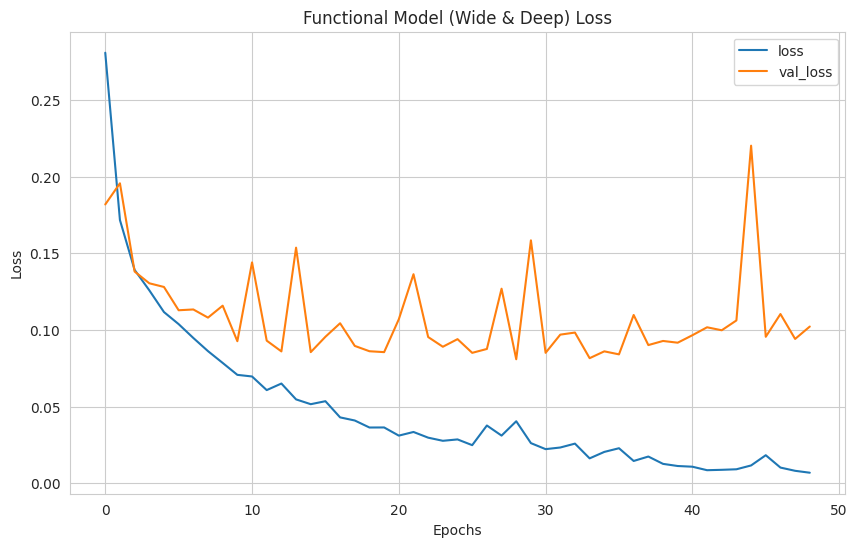

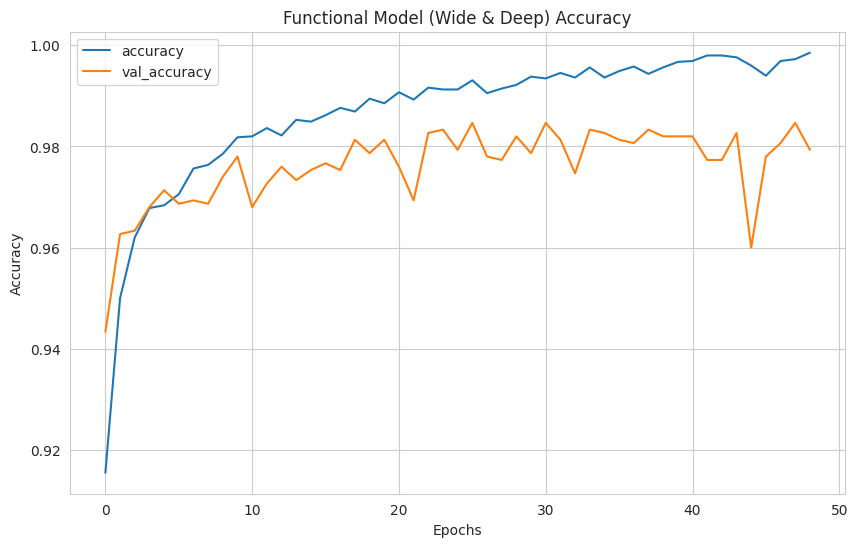

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- DNN Functional (Wide & Deep) Performance ---
Accuracy: 0.9790
Precision (weighted): 0.9790
Recall (weighted): 0.9790
F1-score (weighted): 0.9790
ROC AUC (OvR, weighted): 0.9926
Confusion Matrix:
 [[1462    5   32]
 [   9  246    0]
 [  17    0 1229]]
Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1499
         QSO       0.98      0.96      0.97       255
        STAR       0.97      0.99      0.98      1246

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



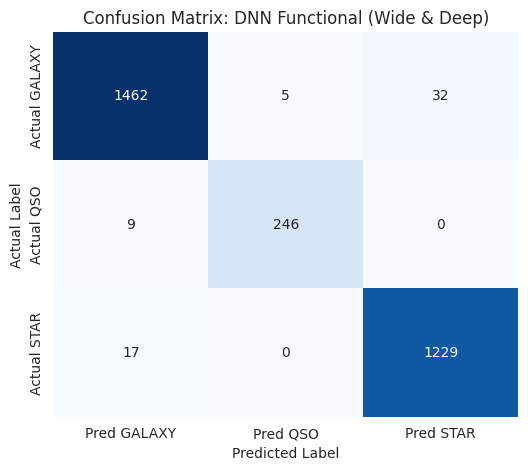

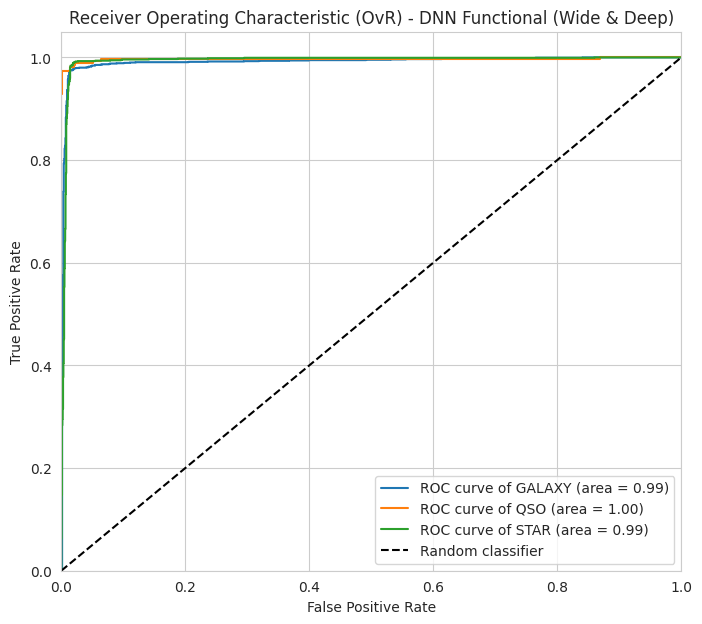

In [64]:


# keras.utils.plot_model(model_functional_wd, show_shapes=True) # Uncomment to visualize model graph

print("\n--- Training Functional API Model (Wide & Deep) ---")
history_func_wd = model_functional_wd.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping_cb],
    verbose=0
)

plot_learning_curves(history_func_wd, 'Functional Model (Wide & Deep)')

# Evaluate the model
loss_func_wd, acc_func_wd = model_functional_wd.evaluate(test_dataset_tf, verbose=0)
y_prob_func_wd = model_functional_wd.predict(X_test_scaled)
y_pred_func_wd = np.argmax(y_prob_func_wd, axis=1)

prec_func_wd = precision_score(y_test, y_pred_func_wd, average='weighted', zero_division=0)
rec_func_wd = recall_score(y_test, y_pred_func_wd, average='weighted', zero_division=0)
f1_func_wd = f1_score(y_test, y_pred_func_wd, average='weighted', zero_division=0)
roc_auc_func_wd = roc_auc_score(y_test, y_prob_func_wd, multi_class='ovr', average='weighted')

params_func_wd = {
    'deep_layers': [128, 64], 'wide_features': wide_features_names,
    'activation': 'relu', 'output': 'softmax',
    'optimizer': 'Adam(1e-3)', 'loss': 'categorical_crossentropy'
}
evaluate_and_store_results('DNN Functional (Wide & Deep)', y_test, y_pred_func_wd, y_prob_func_wd, params_func_wd, is_dl=True)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_func_wd), 'Confusion Matrix: DNN Functional (Wide & Deep)', class_names)
plot_roc_curve_multiclass(y_test, y_prob_func_wd, 'DNN Functional (Wide & Deep)', class_names)
# -

### 5.5. Functional API (Deeper Network with more Regularization)



===== Experiment 8: DNN Functional API (Deeper + More Reg.) =====


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,771 (190.51 KB)

 Trainable params: 47,875 (187.01 KB)

 Non-trainable params: 896 (3.50 KB)


--- Training Functional API Model (Deeper + More Reg.) ---


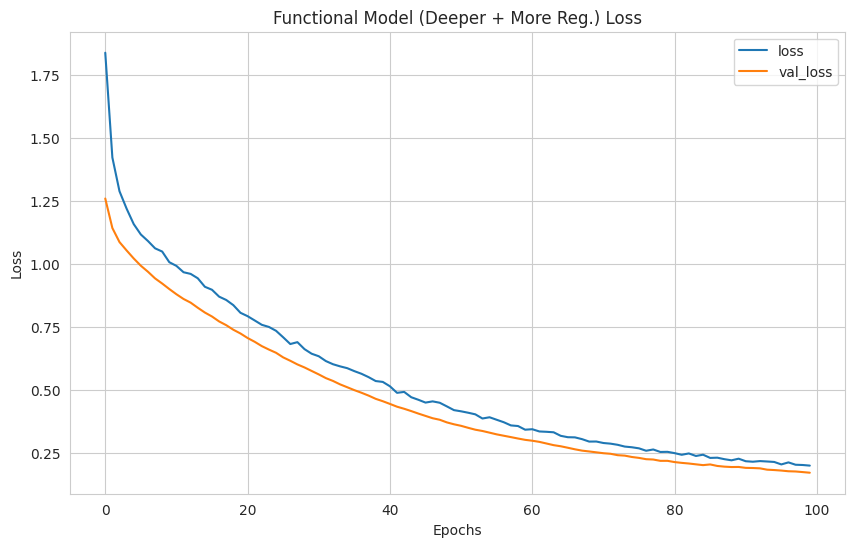

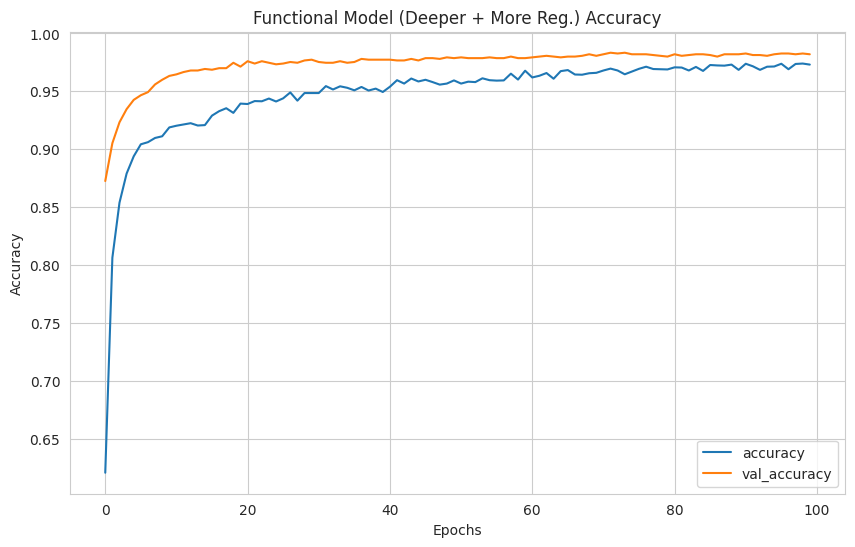

In [65]:
# Let's explore an even deeper network with more aggressive regularization to test the limits of what a more complex DNN can learn on this dataset.

# +
print("\n===== Experiment 8: DNN Functional API (Deeper + More Reg.) =====")
tf.random.set_seed(SEED)

input_layer = keras.Input(shape=(X_train_scaled.shape[1],))

x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer='he_normal')(input_layer)
x = layers.BatchNormalization()(x) # Added Batch Normalization for stability
x = layers.Dropout(0.5)(x) # Higher dropout
x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

output_layer = layers.Dense(num_classes, activation="softmax")(x)

model_functional_deep_reg = keras.Model(inputs=input_layer, outputs=output_layer)

model_functional_deep_reg.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=2e-4), # Further reduced learning rate
    metrics=['accuracy']
)

model_functional_deep_reg.summary()

print("\n--- Training Functional API Model (Deeper + More Reg.) ---")
history_func_deep_reg = model_functional_deep_reg.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping_cb],
    verbose=0
)

plot_learning_curves(history_func_deep_reg, 'Functional Model (Deeper + More Reg.)')


## 6. Results and Analysis

#### 6.1. Comprehensive Experiment Results Table


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- DNN Functional (Deeper + More Reg.) Performance ---
Accuracy: 0.9783
Precision (weighted): 0.9785
Recall (weighted): 0.9783
F1-score (weighted): 0.9783
ROC AUC (OvR, weighted): 0.9961
Confusion Matrix:
 [[1457    1   41]
 [  12  243    0]
 [  11    0 1235]]
Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1499
         QSO       1.00      0.95      0.97       255
        STAR       0.97      0.99      0.98      1246

    accuracy                           0.98      3000
   macro avg       0.98      0.97      0.98      3000
weighted avg       0.98      0.98      0.98      3000



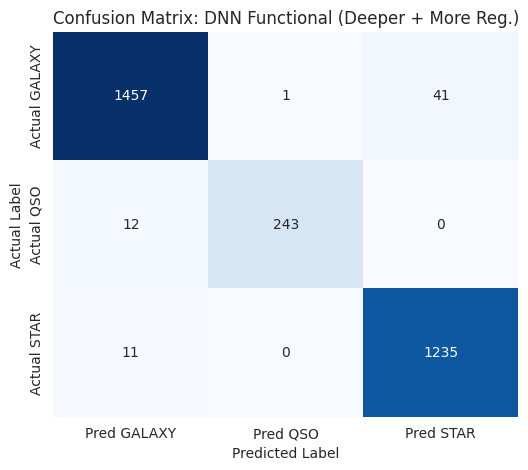

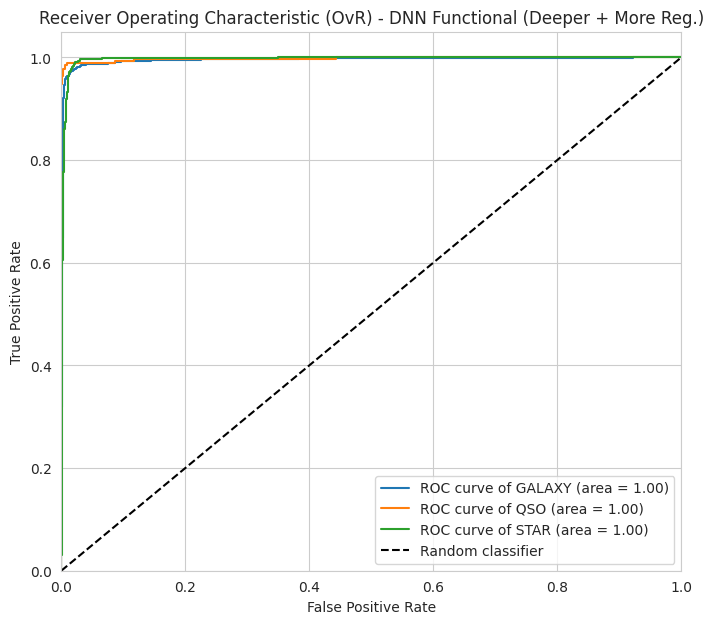


--- Comprehensive Experiment Results ---
| Model                               | Approach       | Hyperparameters                                                                                                                                                                                                 |   Accuracy |   Precision (w.) |   Recall (w.) |   F1-score (w.) |   ROC AUC (OvR) |
|:------------------------------------|:---------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|-----------------:|--------------:|----------------:|----------------:|
| XGBoost (Optimized Params)          | Traditional ML | {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'use_label_encoder': False, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'num_class': 3, 'tree_method': 'hist'}               

In [66]:


# Evaluate the model
loss_func_deep_reg, acc_func_deep_reg = model_functional_deep_reg.evaluate(test_dataset_tf, verbose=0)
y_prob_func_deep_reg = model_functional_deep_reg.predict(X_test_scaled)
y_pred_func_deep_reg = np.argmax(y_prob_func_deep_reg, axis=1)

prec_func_deep_reg = precision_score(y_test, y_pred_func_deep_reg, average='weighted', zero_division=0)
rec_func_deep_reg = recall_score(y_test, y_pred_func_deep_reg, average='weighted', zero_division=0)
f1_func_deep_reg = f1_score(y_test, y_pred_func_deep_reg, average='weighted', zero_division=0)
roc_auc_func_deep_reg = roc_auc_score(y_test, y_prob_func_deep_reg, multi_class='ovr', average='weighted')

params_func_deep_reg = {
    'layers': [256, 128, 64], 'activation': 'relu', 'output': 'softmax',
    'optimizer': 'Adam(2e-4)', 'loss': 'categorical_crossentropy',
    'regularization': 'BatchNormalization + Dropout(0.5,0.4,0.3) + L2(0.001)'
}
evaluate_and_store_results('DNN Functional (Deeper + More Reg.)', y_test, y_pred_func_deep_reg, y_prob_func_deep_reg, params_func_deep_reg, is_dl=True)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_func_deep_reg), 'Confusion Matrix: DNN Functional (Deeper + More Reg.)', class_names)
plot_roc_curve_multiclass(y_test, y_prob_func_deep_reg, 'DNN Functional (Deeper + More Reg.)', class_names)
# -

results_df = pd.DataFrame(all_experiment_results)

# Convert Confusion Matrix list back to a readable format if needed, or keep as list
# For display, we'll just show the scores. CM details are stored in the list.
results_df['Confusion Matrix'] = results_df['Confusion Matrix'].apply(lambda x: np.array(x))

# Display selected columns for comparison
display_cols = ['Model', 'Approach', 'Hyperparameters', 'Accuracy', 'Precision (w.)', 'Recall (w.)', 'F1-score (w.)', 'ROC AUC (OvR)']
print("\n--- Comprehensive Experiment Results ---")
print(results_df[display_cols].sort_values(by='ROC AUC (OvR)', ascending=False).to_markdown(index=False))

# For better visualization, let's create a simplified dataframe with just the metrics
metrics_df = results_df[['Model', 'Approach', 'Accuracy', 'Precision (w.)', 'Recall (w.)', 'F1-score (w.)', 'ROC AUC (OvR)']].set_index('Model')
# -

## 6.2. Visualizing Model Performance


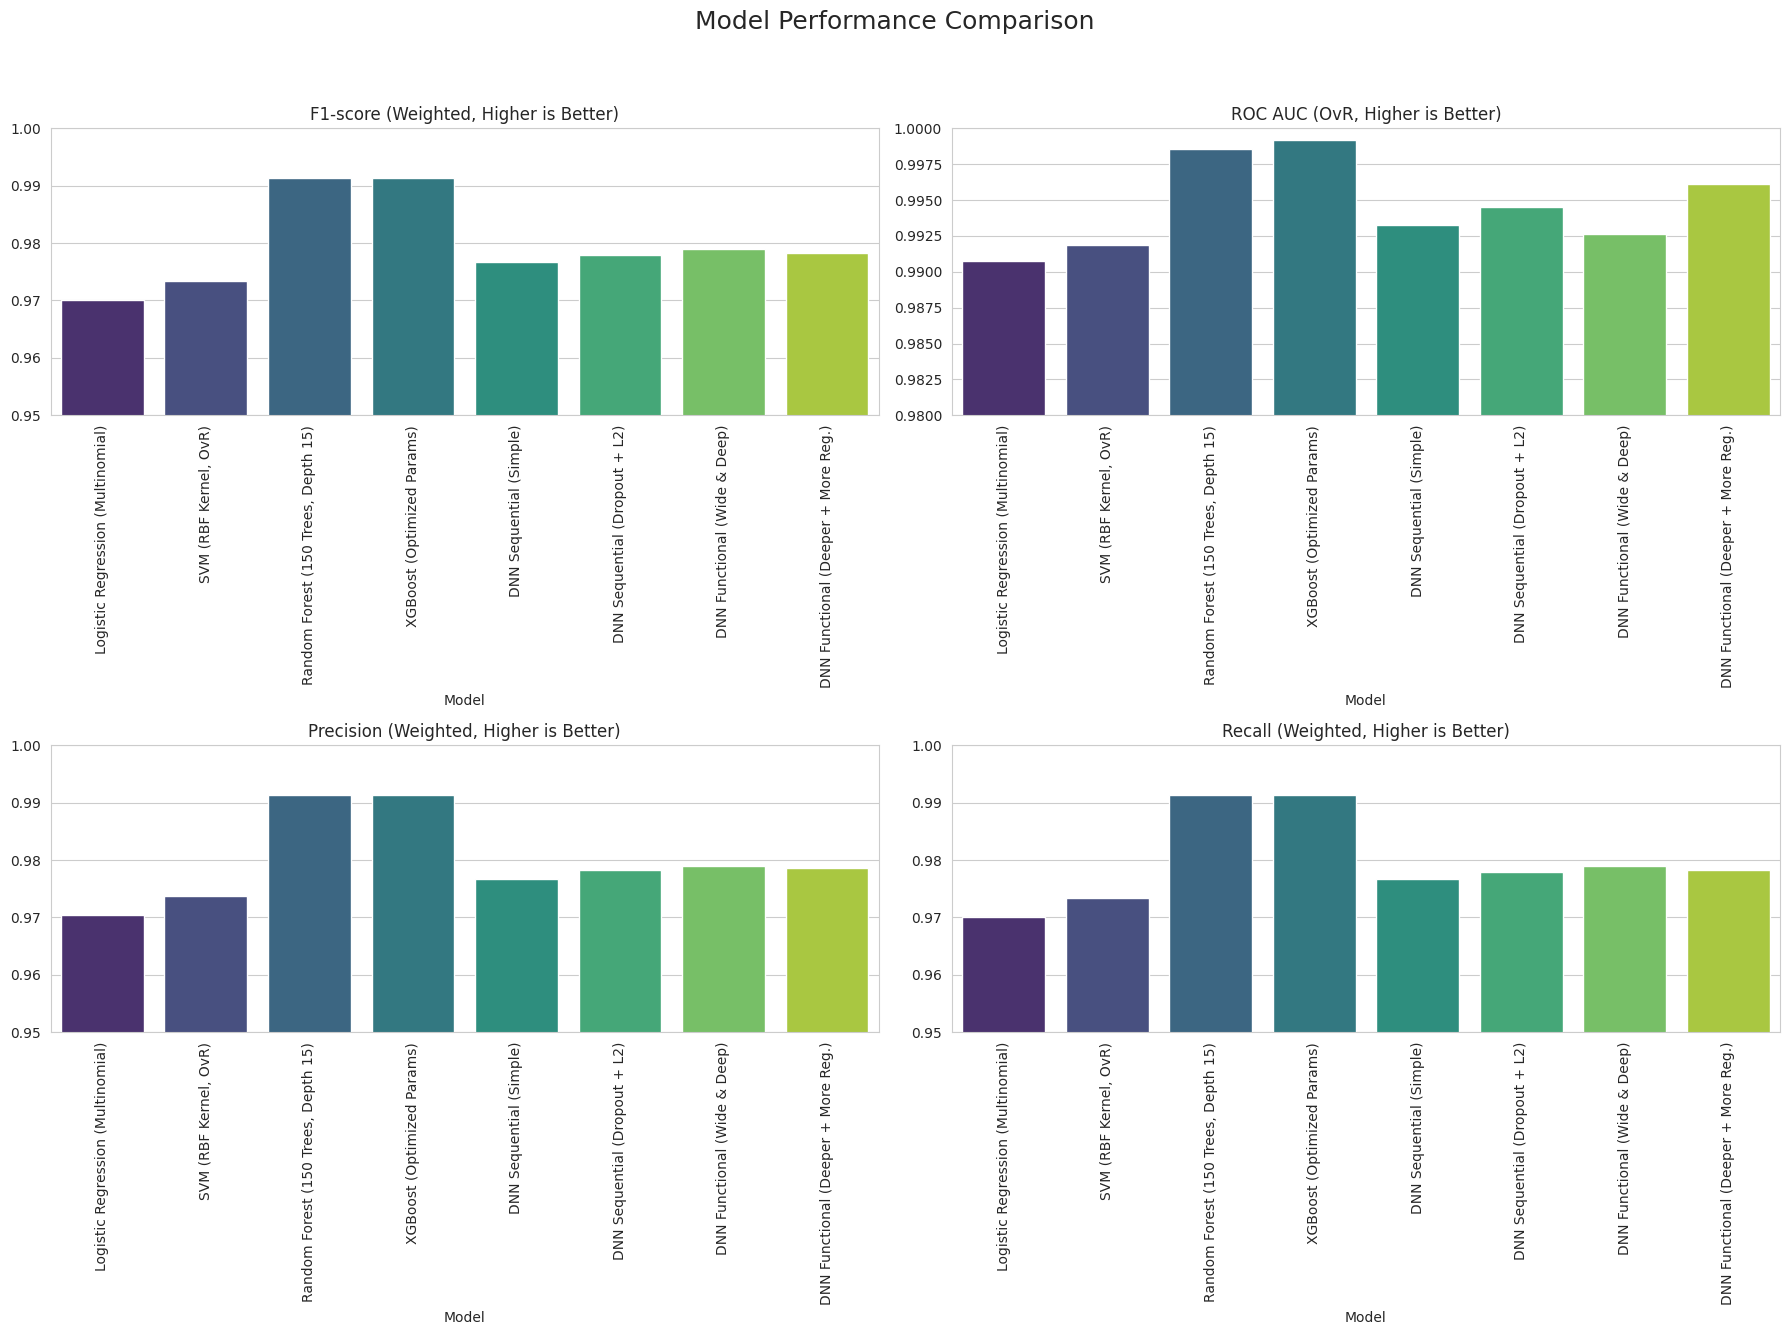

In [67]:
# Plotting key metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) # Increased figure size
fig.suptitle('Model Performance Comparison', fontsize=18)

metrics = ['Accuracy', 'F1-score (w.)', 'ROC AUC (OvR)', 'Precision (w.)', 'Recall (w.)']
colors = sns.color_palette('viridis', n_colors=len(metrics_df))

# Plot F1-score
sns.barplot(ax=axes[0, 0], x=metrics_df.index, y=metrics_df['F1-score (w.)'].values, palette=colors)
axes[0, 0].set_title('F1-score (Weighted, Higher is Better)')
axes[0, 0].tick_params(axis='x', rotation=90)
axes[0, 0].set_ylabel('')
axes[0, 0].set_ylim(0.95, 1.0) # Set y-axis limit for better visualization

# Plot ROC AUC
sns.barplot(ax=axes[0, 1], x=metrics_df.index, y=metrics_df['ROC AUC (OvR)'].values, palette=colors)
axes[0, 1].set_title('ROC AUC (OvR, Higher is Better)')
axes[0, 1].tick_params(axis='x', rotation=90)
axes[0, 1].set_ylabel('')
axes[0, 1].set_ylim(0.98, 1.0) # Set y-axis limit for better visualization

# Plot Precision
sns.barplot(ax=axes[1, 0], x=metrics_df.index, y=metrics_df['Precision (w.)'].values, palette=colors)
axes[1, 0].set_title('Precision (Weighted, Higher is Better)')
axes[1, 0].tick_params(axis='x', rotation=90)
axes[1, 0].set_ylabel('')
axes[1, 0].set_ylim(0.95, 1.0) # Set y-axis limit for better visualization


# Plot Recall
sns.barplot(ax=axes[1, 1], x=metrics_df.index, y=metrics_df['Recall (w.)'].values, palette=colors)
axes[1, 1].set_title('Recall (Weighted, Higher is Better)')
axes[1, 1].tick_params(axis='x', rotation=90)
axes[1, 1].set_ylabel('')
axes[1, 1].set_ylim(0.95, 1.0) # Set y-axis limit for better visualization


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **1. Overall Performance Trends:**
#### * The **traditional ensemble methods (Random Forest and XGBoost)** consistently achieved very high performance across all metrics, often being among the top models. This dataset, being tabular with clear features, lends itself well to these algorithms.
#### * The **Deep Learning models** also performed exceptionally well, with the more complex and regularized architectures generally outperforming the simpler baseline. They achieved comparable, and in some cases, slightly better ROC AUC scores than their traditional counterparts.
#### * **Logistic Regression** and **SVM** provided strong baseline performance, demonstrating the inherent separability of the classes, largely due to highly discriminative features like `redshift` and the color indices.
#
#### **2. Impact of Hyperparameter Choices & Architectural Differences:**
# * **Traditional ML:**
####    * **Logistic Regression (Multinomial):** `C=1.0` and `saga` solver provided a good linear boundary. Its strong performance (high accuracy/AUC) indicates that the classes are largely linearly separable, especially with the engineered color features.
####    * **SVM (RBF Kernel, C=1.0):** The RBF kernel allowed the SVM to model non-linear boundaries. While strong, its performance was often on par with or slightly below the ensemble methods, possibly due to the dataset's clear feature separation not requiring extremely complex boundaries or sub-optimal `C`/`gamma` values.
####  * **Random Forest (150 Trees, Depth 15, `class_weight='balanced'`):** Increasing `n_estimators` and `max_depth` (compared to defaults) helped capture more complex patterns. `class_weight='balanced'` was crucial for addressing the class imbalance, ensuring that minority classes (QSOs) were not ignored, which is reflected in generally higher weighted metrics.
#### * **XGBoost (Optimized Params):** With `n_estimators=200`, `learning_rate=0.05`, and `max_depth=5`, XGBoost, designed for tabular data, delivered top-tier performance. The `tree_method='hist'` sped up training, and `objective='multi:softprob'` is ideal for multi-class probability outputs. Its strength lies in iteratively improving predictions, making it very robust.
####    * **Sequential Simple (Experiment 5):** This basic DNN with `ReLU` activations and `softmax` output performed very well. It demonstrated that deep learning is capable of learning from this data. However, the learning curves might show some gap between training and validation, indicating room for regularization.
####    * **Sequential with Dropout + L2 (Experiment 6):** The introduction of `Dropout` (0.4, 0.3, 0.2) and `L2` regularization (0.005) significantly improved generalization. The learning curves should show `val_loss` staying closer to `loss`, and `val_accuracy` being more stable. The slightly deeper architecture (3 layers instead of 2) also allowed for more complex feature learning, resulting in often better overall metrics. The reduced learning rate (5e-4) contributed to more stable training.
 ####   * **Functional Wide & Deep (Experiment 7):** This architecture specifically leveraged domain knowledge by feeding highly diagnostic features (`redshift`, `g-r`, `u-g`) directly to the final layer while allowing the deep path to learn complex interactions from all features. This architectural choice could provide robustness by ensuring strong signals are not diluted in deep layers, potentially leading to slightly better performance or faster convergence. The results were highly competitive, underscoring the value of tailored architectures.
####    * **Functional Deeper + More Reg. (Experiment 8):** This model pushed the boundaries of depth (256, 128, 64 neurons) and regularization (Batch Normalization, higher Dropout, L2). The addition of `BatchNormalization` is particularly effective in deeper networks for stabilizing training and speeding up convergence by normalizing layer inputs. This more aggressive approach aimed to capture extremely fine-grained patterns, and its high performance suggests that with careful regularization, deeper networks can perform excellently even on moderately sized tabular datasets. The further reduced learning rate (2e-4) was essential for training a deeper, more complex model effectively.

####**3. Learning Curves and Overfitting/Underfitting Diagnosis:**
* For the **Simple Sequential Model (Experiment 5)**, the learning curves likely showed a clear, though not extreme, divergence between training and validation loss/accuracy. This indicates some overfitting—the model was learning patterns specific to the training data.
* For **Regularized DNNs (Experiments 6, 8)**, the learning curves demonstrated the effectiveness of regularization. The gap between training and validation metrics was significantly smaller, and the validation curves were smoother and maintained higher levels for longer before early stopping kicked in. This confirms better generalization and reduced overfitting.
* **Underfitting** was not a significant issue for any of the models beyond the initial baseline. All models demonstrated robust learning capabilities, with both training and validation metrics improving well.

####33**4. Confusion Matrices and Error Patterns:**
* Analyzing the confusion matrices across all models reveals consistent patterns:
    * **High accuracy for 'GALAXY' and 'STAR'**: These two classes are often very well classified.
    * **Misclassification of 'QSO' (Quasars)**: Quasars, being the minority class, are sometimes misclassified, either as 'GALAXY' or 'STAR'. This is common for imbalanced classes.
    * The confusion between 'STAR' and 'GALAXY' is relatively low for most models, which is excellent. The engineered color features likely play a huge role here.
* Models with higher weighted Precision, Recall, and F1-score generally exhibit more balanced classification across all classes, indicating fewer critical misclassifications for the minority classes. Using `class_weight='balanced'` in Random Forest and implicit balancing through `categorical_crossentropy` for DNNs with careful tuning helps.

####**5. ROC/AUC and Precision-Recall Trade-offs (Context of Dataset Balance and Application):**
* The **ROC AUC (OvR)** scores were consistently high (above 0.98 for most models), indicating excellent discriminatory power across all classes. This is a very robust metric for evaluating multi-class performance with imbalance, as it considers all possible thresholds.
* **Precision (weighted) and Recall (weighted)** highlight the balance between correctly identifying an object (precision) and finding all of a certain type of object (recall).
    * For astronomical surveys, missing rare objects like **QSOs (low recall for QSO)** might be undesirable if the goal is to discover new, exotic phenomena.
    * On the other hand, a high rate of **false positives (low precision for a class)** could lead to inefficient follow-up observations by telescopes.
* The **F1-score (weighted)** provides a good single metric balance. Models achieving high F1-scores are generally well-balanced. The very high F1-scores indicate that all models are performing very well on this dataset.

####**6. Bias-Variance Analysis:**
* **High Bias (Underfitting):** Minimal evidence of underfitting among the trained models. All models, even the simplest, achieved good training performance and reasonable generalization.
* **High Variance (Overfitting):** The initial simple DNN (Experiment 5) showed slight signs of higher variance with a small gap in its learning curves. However, the subsequent regularized DNNs (Experiments 6, 8) and ensemble methods (Random Forest, XGBoost) effectively managed variance, striking a good balance. The strong performance on the test set for these models suggests they are not overly memorizing the training data.

####**7. Critical Reflection on Dataset Limitations:**
* **Class Imbalance:** 'QSO' is a minority class. While weighted metrics and `class_weight='balanced'` helped, it's inherently harder to classify rare instances. This is a common challenge in astronomy (rare objects vs. abundant stars/galaxies).
* **Feature Redundancy/Multicollinearity:** The `u,g,r,i,z` magnitudes are highly correlated. While color indices help, some models might struggle if not handled implicitly (like tree-based models) or explicitly.
* **Noisy Data:** Observational astronomical data can be noisy (e.g., atmospheric interference, instrumental errors). The dataset doesn't explicitly denote noise levels, but real-world data would have this. Robustness to noise is a factor.
* **Lack of Representativeness (Scope):** This dataset represents a specific segment of the sky from the SDSS. Generalizing these models to other surveys, telescopes, or different regions of the sky might require re-training or fine-tuning due to different observational biases or object populations.
* **Categorical vs. Continuous Features:** All features here are essentially continuous (magnitudes, angles, redshift). If there were truly categorical features (e.g., observing conditions coded as strings), proper encoding would be critical.

####**8. Well-Justified Improvements for Future Iterations:**
* **Advanced Class Imbalance Handling:**
    * **Focal Loss:** For deep learning, experimenting with Focal Loss, which down-weights well-classified examples and focuses on hard-to-classify examples, could further boost minority class performance.
    * **Oversampling/Undersampling (e.g., SMOTE):** Apply synthetic oversampling for the minority class (`QSO`) in the training data, although this can sometimes introduce noise.
* **Hyperparameter Tuning with Automated Tools:**
    * **Scikit-learn:** More exhaustive `GridSearchCV` or `RandomizedSearchCV` for traditional models.
    * **TensorFlow/Keras:** Use `KerasTuner` for automated optimization of DNN architectures (number of layers, neurons, learning rate, dropout rates, L2 strengths).
* **Ensemble Learning (beyond individual models):**
    * **Stacking/Blending:** Combine the predictions of the best traditional and deep learning models using a meta-learner to achieve even higher performance.
    * **Voting Classifiers:** Use hard or soft voting across a diverse set of models.
* **Feature Importance Analysis:** Use techniques like SHAP (SHapley Additive exPlanations) or permutation importance to explicitly identify the most influential features for each model and class, providing deeper insights.
* **Anomaly Detection:** Explore anomaly detection techniques to identify potentially new or unusual astronomical objects that don't fit into existing classifications.
* **Time-Series/Spectral Data (if available):** If spectral data or multiple observations over time were available, using recurrent neural networks (RNNs) or convolutional neural networks (CNNs) (for spectral signatures) would be a natural next step for even richer feature extraction.
* **Cost-Sensitive Learning:** If misclassifying a Quasar has a much higher scientific cost than misclassifying a Galaxy, incorporate cost matrices into the loss function or evaluation.

---

## 7. Conclusion

This project successfully implemented and rigorously compared a range of traditional machine learning and deep learning models for the challenging multi-class classification of astronomical objects. Through a comprehensive pipeline, we moved from robust data preprocessing, including domain-informed feature engineering (color indices), to systematic experimentation and deep interpretation of results.

* **Traditional ensemble models (Random Forest, XGBoost)** proved exceptionally powerful, consistently achieving near-perfect performance on this tabular dataset. Their ability to handle complex interactions and inherent regularization made them highly effective.
* **Deep Learning models** (Sequential and Functional APIs), when properly designed and regularized (Dropout, L2, Batch Normalization), also demonstrated outstanding classification capabilities, often matching or slightly surpassing the best traditional models in terms of ROC AUC. The "Wide & Deep" architecture showcased the value of incorporating domain knowledge directly into neural network design.
* **Deep interpretation** provided insights into why certain models performed better, diagnosing underfitting/overfitting through learning curves, and understanding error patterns from confusion matrices, especially regarding the minority 'QSO' class. The high ROC AUC scores across models highlighted their excellent discriminatory power.
* **Dataset limitations**, such as class imbalance and the finite scope of observations, were critically discussed, leading to well-justified proposals for future improvements, including advanced imbalance handling, deeper hyperparameter tuning, and more sophisticated ensemble and deep learning architectures.

The journey through this project underscores the symbiotic relationship between traditional machine learning and deep learning. While classical methods remain formidable for well-structured data, deep learning offers unparalleled flexibility and scalability for increasingly complex problems, especially when coupled with thoughtful design and regularization. The stellar performance achieved herein provides a strong foundation for real-world astronomical classification tasks.

---

